# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [ ]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label




In [ ]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            #A.RandomRotate90(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.Flip(),
            # A.Transpose(),
            #A.GaussNoise(),
            A.OneOf([
                A.MotionBlur(p=.2),
                #A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf([
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=.1),
            ], p=0.2),
            A.RandomGridShuffle(grid = (3,3), always_apply=False, p = 0.3),
            A.RandomBrightnessContrast(brightness_limit = 0.2,
                                        contrast_limit = 0.2,
                                        always_apply = False,
                                        p = 0.2
                                      ),
            #A.Sharpen(alpha=(0.2, 0.5), lightness = (0.5, 1.0), always_apply=False, p = 0.5),
            A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
            # A.RandomCrop(height=64, width=128, p=1),
            # A.OneOf([
            #     #A.CLAHE(clip_limit=2),
            #     A.RandomBrightnessContrast(),
            # ], p=0.3),
            # A.HueSaturationValue(p=0.3),
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...


<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'num_holes' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_h_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'max_w_size' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'fill_value' is not valid and will be ignored.
  A.CoarseDropout(num_holes=8, max_h_size = 8, max_w_size = 8, fill_value=0, mask_fill_value=0, always_apply=False, p = 0.5)
<ipython-input-12-62be4001c797>:58: UserWarning: Argument 'mask_fill_value' is no

WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


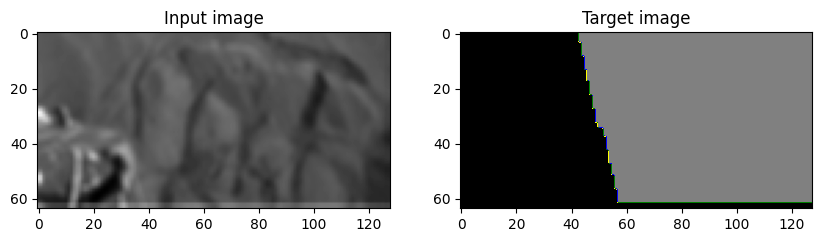

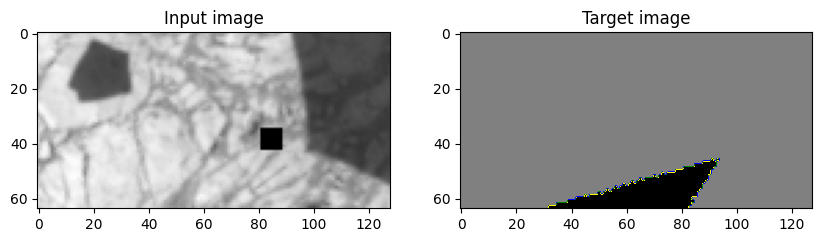

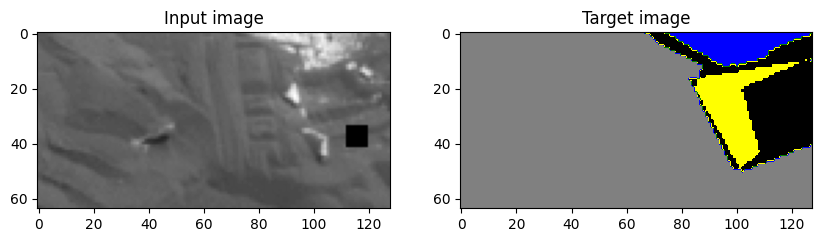

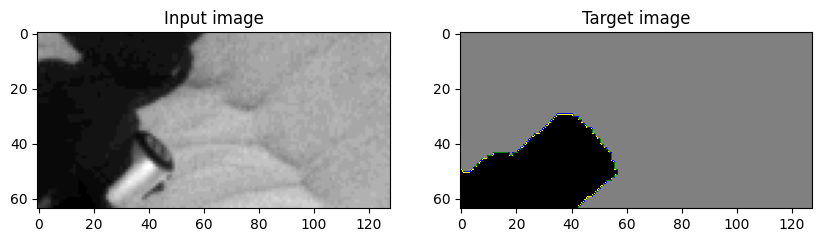

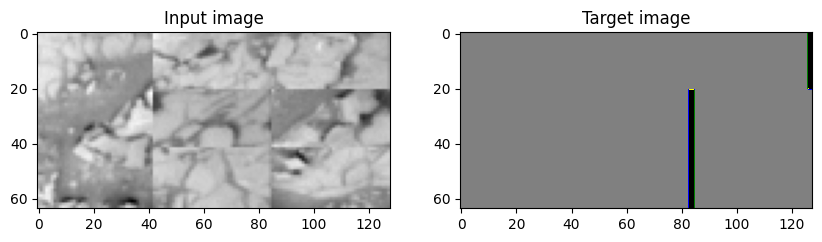

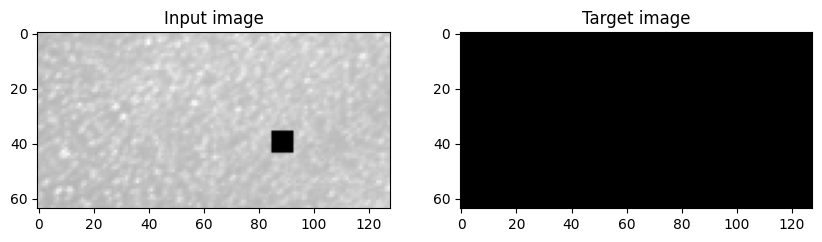

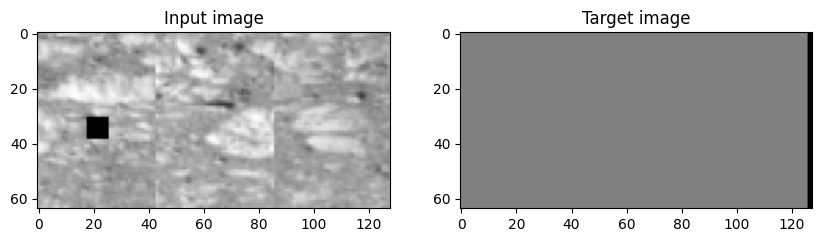

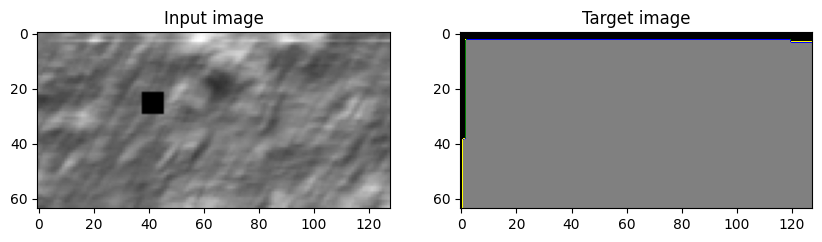

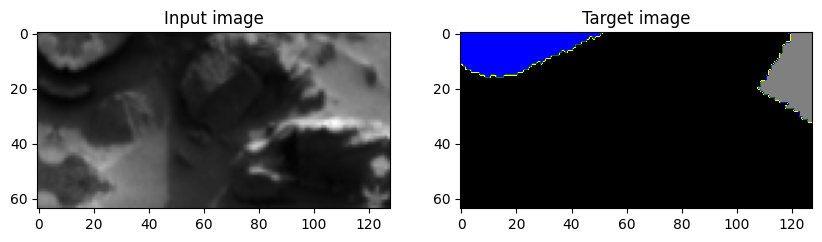

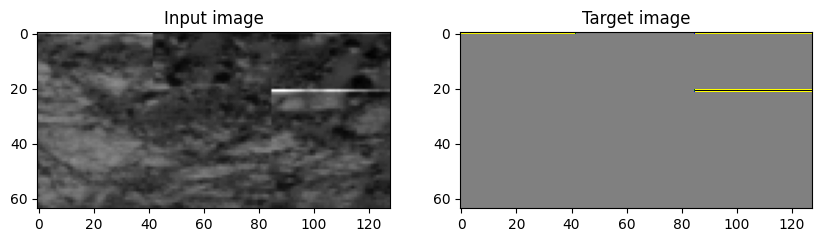

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [ ]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 32)  │          128 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 32)  │           64 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 32)  │        9,248 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 32)  │          128 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 32)  │          128 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 32)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 32)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 64)   │          256 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 64)   │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 9,787,005 (37.33 MB)

 Trainable params: 9,776,243 (37.29 MB)

 Non-trainable params: 10,762 (42.04 KB)

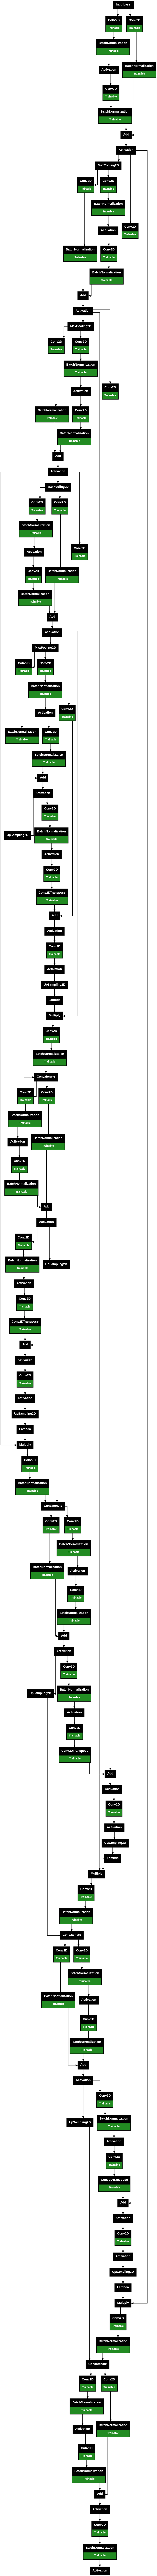

In [ ]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = 0.1
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(X_train.shape[0]/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    mask = tf.cast(tf.reduce_sum(y_true, axis=-1) > 0, tf.float32) #ignore class 0

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss

    focal_loss = focal_loss * tf.expand_dims(mask, axis=-1)
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    mask = tf.cast(tf.reduce_sum(y_true, axis=-1) > 0, tf.float32)

    # Compute Dice coefficient
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)

    # Apply mask to ignore class 0
    dice = dice * mask

    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    """
    Combined Focal Loss and Dice Loss that ignores class 0.

    Args:
        y_true (tf.Tensor): Ground truth tensor of shape (batch_size, height, width, num_classes).
        y_pred (tf.Tensor): Prediction tensor of shape (batch_size, height, width, num_classes).
        alpha (float): Balancing factor for focal loss.
        gamma (float): Focusing parameter for focal loss.
        epsilon (float): Smoothing constant for dice loss.

    Returns:
        tf.Tensor: Combined loss value (Focal + Dice Loss).
    """
    # Mask to ignore class 0 in both losses
    mask = tf.cast(tf.reduce_sum(y_true, axis=-1) > 0, tf.float32)  # Exclude class 0

    # Calculate focal loss
    focal = focal_loss(y_true, y_pred, alpha, gamma)

    # Calculate dice loss
    dice = dice_loss(y_true, y_pred, epsilon)

    # Apply mask to focal and dice loss to ignore class 0
    focal = focal * mask
    dice = dice * mask

    return tf.reduce_mean(focal + dice)

print("Compiling model...")
model.compile(
    # loss=combined_loss,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=0),
    optimizer=tf.keras.optimizers.AdamW(lr_schedule, beta_1=0.99),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=30,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.1,
    patience=40
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2880 - loss: 1.4841 - mean_iou: 0.1247   

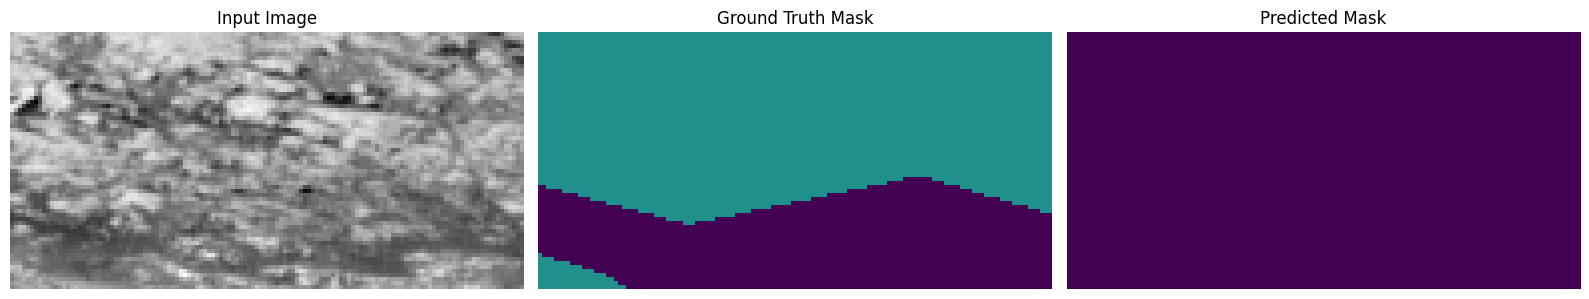

30/30 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.2888 - loss: 1.4816 - mean_iou: 0.1251 - val_accuracy: 0.2445 - val_loss: 1.9094 - val_mean_iou: 0.0000e+00
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.3399 - loss: 1.2908 - mean_iou: 0.1785 - val_accuracy: 0.2445 - val_loss: 1.9354 - val_mean_iou: 0.0000e+00
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.3635 - loss: 1.2398 - mean_iou: 0.1958 - val_accuracy: 0.2445 - val_loss: 1.9929 - val_mean_iou: 0.0000e+00
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.3767 - loss: 1.2333 - mean_iou: 0.2062 - val_accuracy: 0.2445 - val_loss: 2.1251 - val_mean_iou: 0.0000e+00
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.3839 - loss: 1.2265 - mean_iou: 0.2103 - val_accuracy: 0.2445 - val_loss: 2.1302 - val_mean_iou: 0.0000e+00
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4233 - loss: 1.2110 - mean_iou: 0.2084

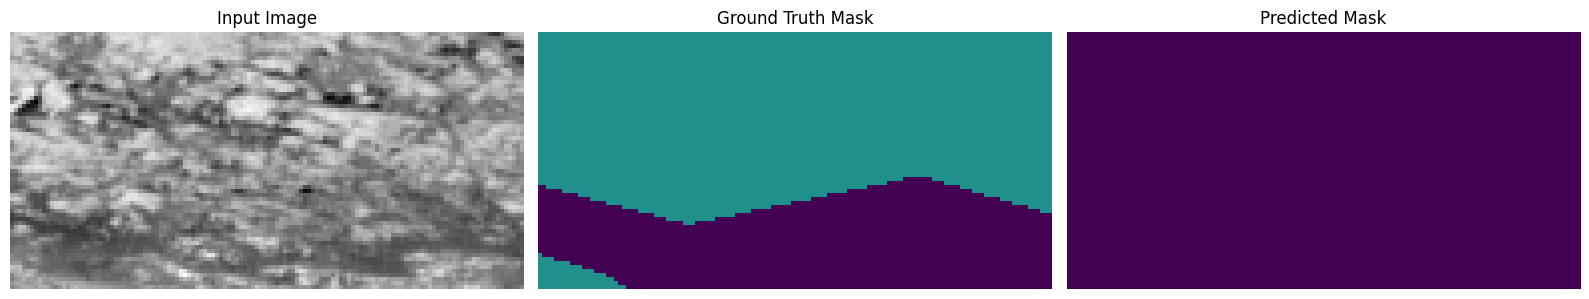

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.4229 - loss: 1.2109 - mean_iou: 0.2080 - val_accuracy: 0.2445 - val_loss: 2.1278 - val_mean_iou: 0.0000e+00
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.4118 - loss: 1.2111 - mean_iou: 0.2416 - val_accuracy: 0.2445 - val_loss: 2.0757 - val_mean_iou: 0.0000e+00
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.4240 - loss: 1.2101 - mean_iou: 0.2635 - val_accuracy: 0.2446 - val_loss: 2.0756 - val_mean_iou: 3.5989e-04
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.3933 - loss: 1.2290 - mean_iou: 0.2552 - val_accuracy: 0.2525 - val_loss: 2.0500 - val_mean_iou: 0.0240
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.4010 - loss: 1.2366 - mean_iou: 0.2322 - val_accuracy: 0.1994 - val_loss: 1.7228 - val_mean_iou: 0.0752
Epoch 11/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.4187 - loss: 1.1945 - mean_iou: 0.2587

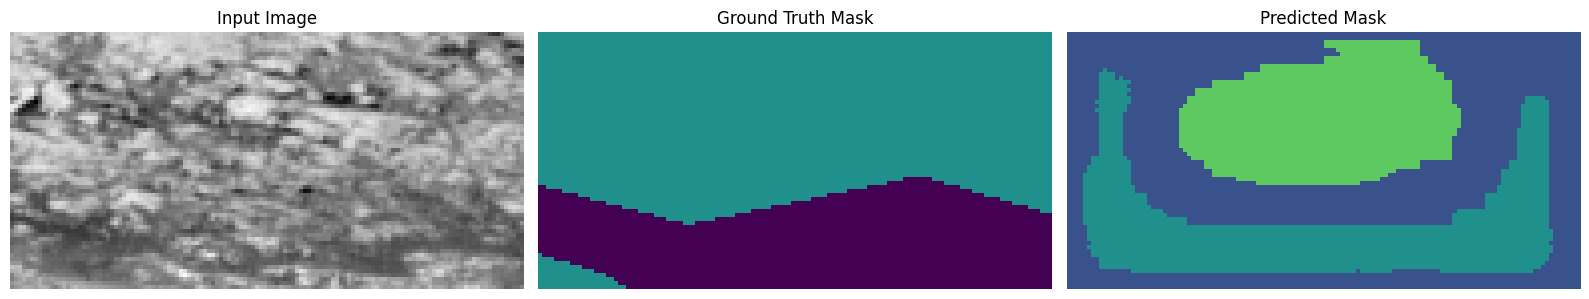

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.4184 - loss: 1.1945 - mean_iou: 0.2584 - val_accuracy: 0.1776 - val_loss: 1.5813 - val_mean_iou: 0.0738
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.4228 - loss: 1.2006 - mean_iou: 0.2507 - val_accuracy: 0.3307 - val_loss: 1.3764 - val_mean_iou: 0.1095
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.4240 - loss: 1.1877 - mean_iou: 0.2564 - val_accuracy: 0.3310 - val_loss: 1.3749 - val_mean_iou: 0.1095
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.4414 - loss: 1.1848 - mean_iou: 0.2692 - val_accuracy: 0.3310 - val_loss: 1.3749 - val_mean_iou: 0.1095
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.4330 - loss: 1.1838 - mean_iou: 0.2665 - val_accuracy: 0.3310 - val_loss: 1.3749 - val_mean_iou: 0.1095
Epoch 16/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.4385 - loss: 1.1770 - mean_iou: 0.2719

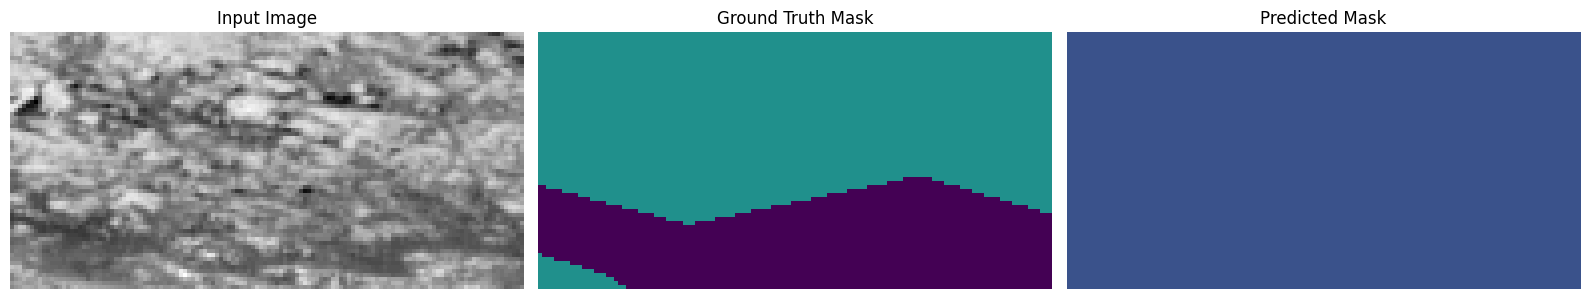

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 391ms/step - accuracy: 0.4383 - loss: 1.1770 - mean_iou: 0.2718 - val_accuracy: 0.3321 - val_loss: 1.3663 - val_mean_iou: 0.1113
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.4318 - loss: 1.1935 - mean_iou: 0.2615 - val_accuracy: 0.4019 - val_loss: 1.2433 - val_mean_iou: 0.2238
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.4325 - loss: 1.1850 - mean_iou: 0.2626 - val_accuracy: 0.4128 - val_loss: 1.2086 - val_mean_iou: 0.2461
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4311 - loss: 1.1853 - mean_iou: 0.2640 - val_accuracy: 0.4077 - val_loss: 1.2261 - val_mean_iou: 0.2415
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.4441 - loss: 1.1776 - mean_iou: 0.2952 - val_accuracy: 0.4051 - val_loss: 1.1991 - val_mean_iou: 0.2407
Epoch 21/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4340 - loss: 1.1812 - mean_iou: 0.2675

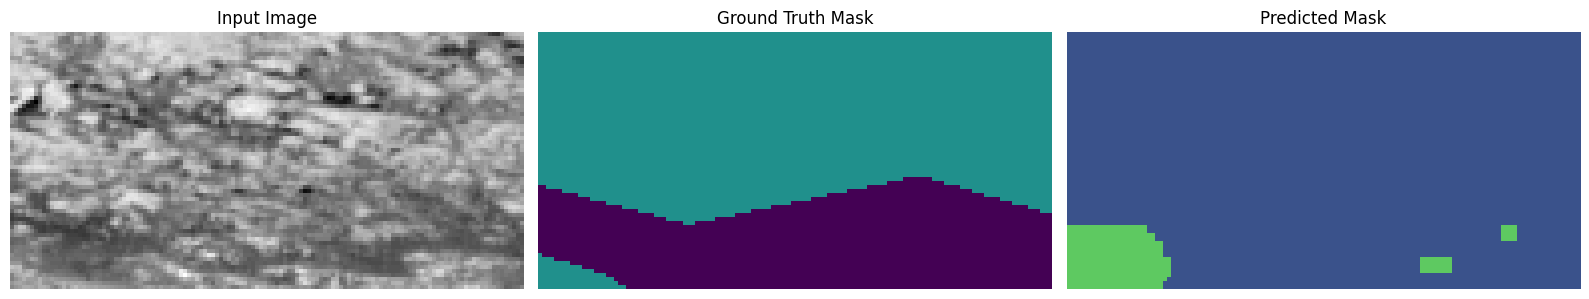

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.4339 - loss: 1.1813 - mean_iou: 0.2674 - val_accuracy: 0.4097 - val_loss: 1.2168 - val_mean_iou: 0.2445
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.4376 - loss: 1.1792 - mean_iou: 0.2699 - val_accuracy: 0.4556 - val_loss: 1.1439 - val_mean_iou: 0.3051
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.4500 - loss: 1.1686 - mean_iou: 0.2870 - val_accuracy: 0.3747 - val_loss: 1.2567 - val_mean_iou: 0.1774
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.4379 - loss: 1.1798 - mean_iou: 0.2734 - val_accuracy: 0.4206 - val_loss: 1.2026 - val_mean_iou: 0.2506
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.4233 - loss: 1.1880 - mean_iou: 0.2907 - val_accuracy: 0.3395 - val_loss: 1.2395 - val_mean_iou: 0.1259
Epoch 26/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4085 - loss: 1.1842 - mean_iou: 0.3049

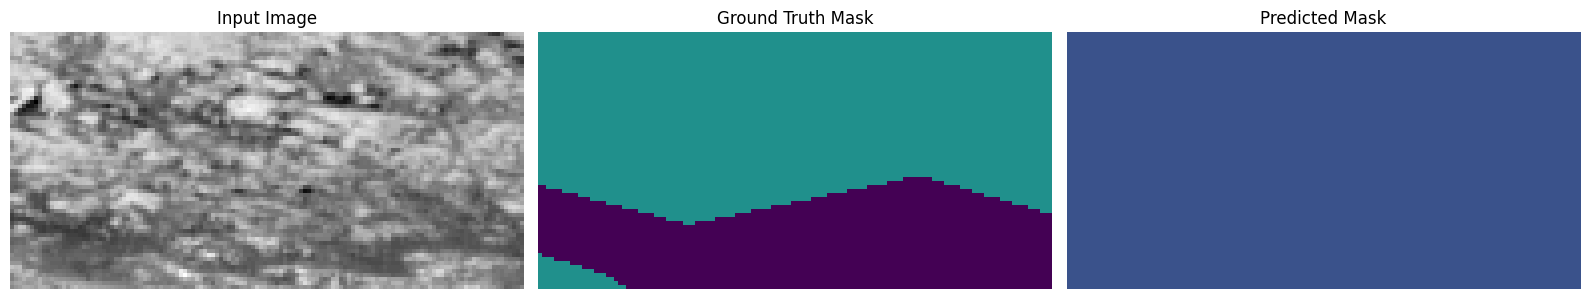

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.4087 - loss: 1.1841 - mean_iou: 0.3051 - val_accuracy: 0.3310 - val_loss: 1.3747 - val_mean_iou: 0.1095
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.4447 - loss: 1.1726 - mean_iou: 0.2861 - val_accuracy: 0.3310 - val_loss: 1.3751 - val_mean_iou: 0.1095
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.4458 - loss: 1.1781 - mean_iou: 0.2802 - val_accuracy: 0.3528 - val_loss: 1.3143 - val_mean_iou: 0.1532
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4541 - loss: 1.1703 - mean_iou: 0.2911 - val_accuracy: 0.3642 - val_loss: 1.2747 - val_mean_iou: 0.1732
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.4494 - loss: 1.1758 - mean_iou: 0.2798 - val_accuracy: 0.4129 - val_loss: 1.2236 - val_mean_iou: 0.2466
Epoch 31/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4461 - loss: 1.1758 - mean_iou: 0.2777

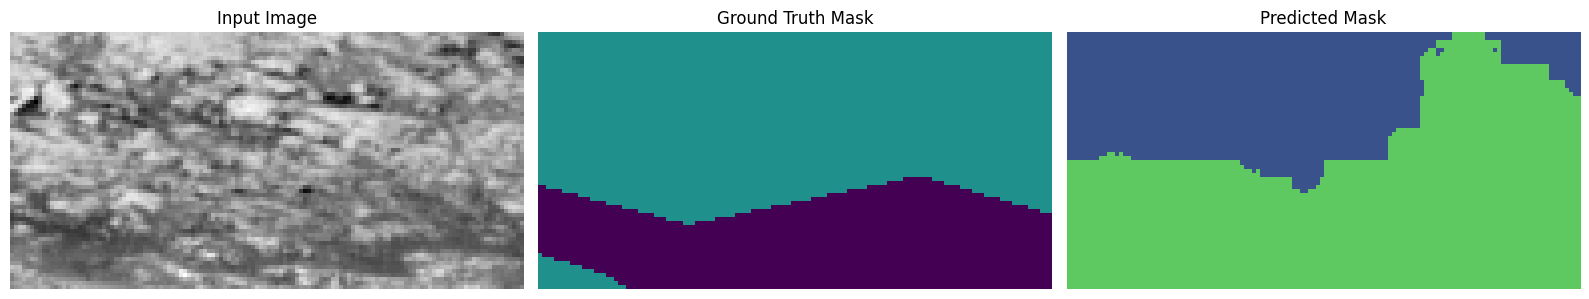

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.4459 - loss: 1.1758 - mean_iou: 0.2776 - val_accuracy: 0.3680 - val_loss: 1.2488 - val_mean_iou: 0.2059
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.4424 - loss: 1.1760 - mean_iou: 0.2739 - val_accuracy: 0.3777 - val_loss: 1.2428 - val_mean_iou: 0.2142
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.4503 - loss: 1.1679 - mean_iou: 0.2826 - val_accuracy: 0.4282 - val_loss: 1.1688 - val_mean_iou: 0.2663
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.4468 - loss: 1.1799 - mean_iou: 0.2819 - val_accuracy: 0.4427 - val_loss: 1.1585 - val_mean_iou: 0.2863
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4498 - loss: 1.1676 - mean_iou: 0.2871 - val_accuracy: 0.4409 - val_loss: 1.1585 - val_mean_iou: 0.2835
Epoch 36/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4496 - loss: 1.1756 - mean_iou: 0.2938

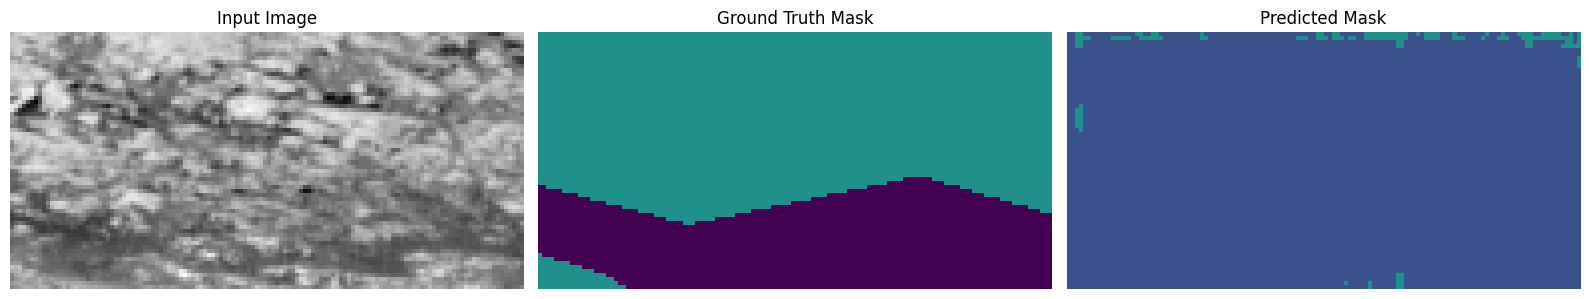

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - accuracy: 0.4495 - loss: 1.1755 - mean_iou: 0.2940 - val_accuracy: 0.4316 - val_loss: 1.2020 - val_mean_iou: 0.2723
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.4447 - loss: 1.1813 - mean_iou: 0.2907 - val_accuracy: 0.4423 - val_loss: 1.1776 - val_mean_iou: 0.2887
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.4509 - loss: 1.1683 - mean_iou: 0.2955 - val_accuracy: 0.4467 - val_loss: 1.1691 - val_mean_iou: 0.2901
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.4436 - loss: 1.1705 - mean_iou: 0.3013 - val_accuracy: 0.4588 - val_loss: 1.1613 - val_mean_iou: 0.3172
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4431 - loss: 1.1724 - mean_iou: 0.3036 - val_accuracy: 0.4358 - val_loss: 1.1864 - val_mean_iou: 0.2747
Epoch 41/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4443 - loss: 1.1686 - mean_iou: 0.2917

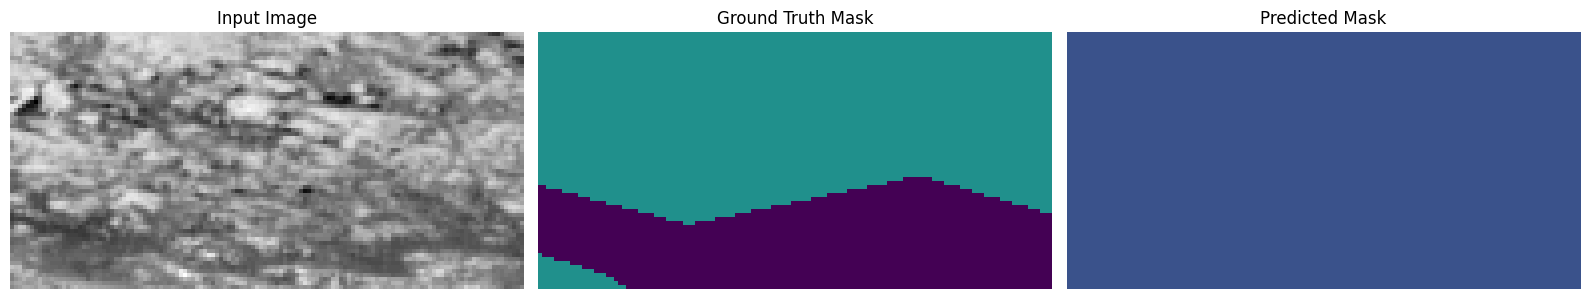

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - accuracy: 0.4442 - loss: 1.1685 - mean_iou: 0.2916 - val_accuracy: 0.4391 - val_loss: 1.1548 - val_mean_iou: 0.2806
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.4496 - loss: 1.1776 - mean_iou: 0.2896 - val_accuracy: 0.4281 - val_loss: 1.1920 - val_mean_iou: 0.2670
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.4495 - loss: 1.1634 - mean_iou: 0.2882 - val_accuracy: 0.3775 - val_loss: 1.2266 - val_mean_iou: 0.2091
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.4477 - loss: 1.1767 - mean_iou: 0.2835 - val_accuracy: 0.3795 - val_loss: 1.2662 - val_mean_iou: 0.2215
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.4441 - loss: 1.1766 - mean_iou: 0.2924 - val_accuracy: 0.3878 - val_loss: 1.2270 - val_mean_iou: 0.2547
Epoch 46/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4617 - loss: 1.1692 - mean_iou: 0.3208

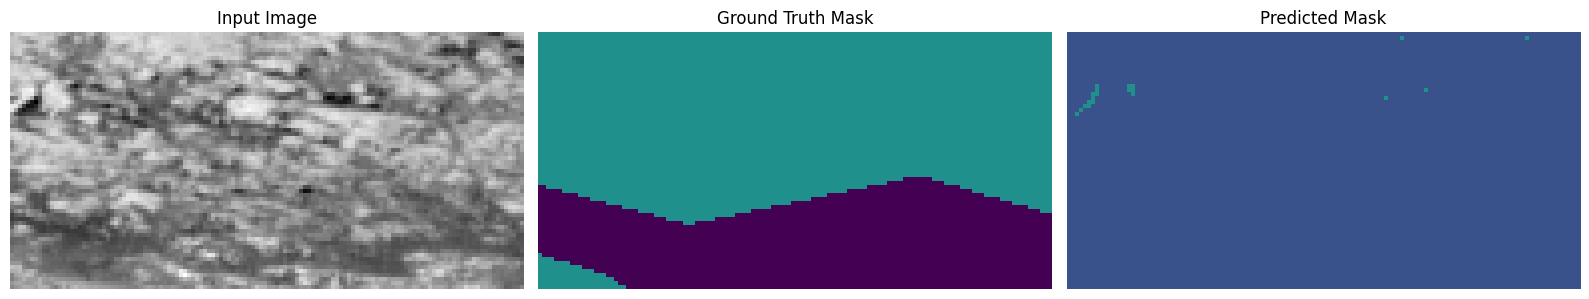

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.4614 - loss: 1.1692 - mean_iou: 0.3207 - val_accuracy: 0.4615 - val_loss: 1.1546 - val_mean_iou: 0.3355
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.4579 - loss: 1.1718 - mean_iou: 0.3179 - val_accuracy: 0.4592 - val_loss: 1.1612 - val_mean_iou: 0.3278
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.4565 - loss: 1.1700 - mean_iou: 0.3332 - val_accuracy: 0.4058 - val_loss: 1.1502 - val_mean_iou: 0.3127
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.4393 - loss: 1.1710 - mean_iou: 0.3312 - val_accuracy: 0.4547 - val_loss: 1.1472 - val_mean_iou: 0.3272
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.4455 - loss: 1.1754 - mean_iou: 0.3241 - val_accuracy: 0.4390 - val_loss: 1.1744 - val_mean_iou: 0.3053
Epoch 51/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4543 - loss: 1.1868 - mean_iou: 0.3237

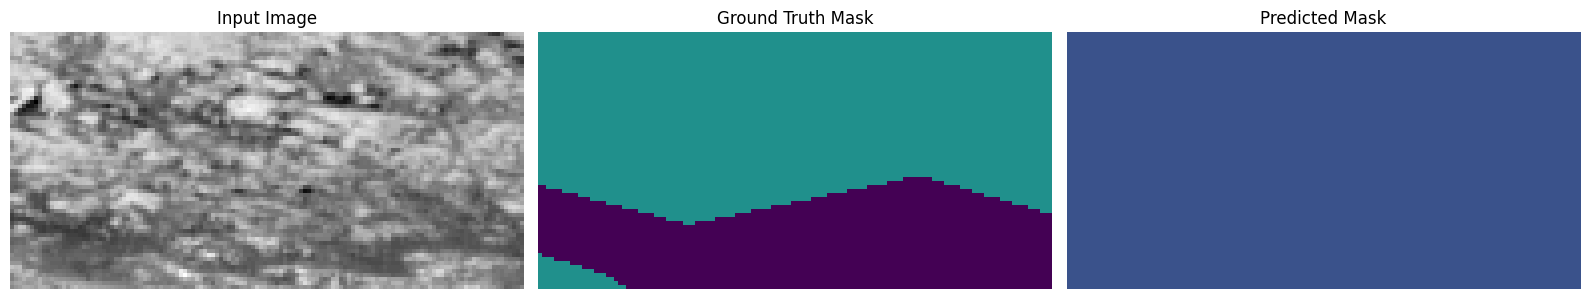

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.4540 - loss: 1.1866 - mean_iou: 0.3237 - val_accuracy: 0.4040 - val_loss: 1.2302 - val_mean_iou: 0.2355
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 0.4494 - loss: 1.1657 - mean_iou: 0.3222 - val_accuracy: 0.3456 - val_loss: 1.2744 - val_mean_iou: 0.1875
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.4542 - loss: 1.1735 - mean_iou: 0.3325 - val_accuracy: 0.4358 - val_loss: 1.2170 - val_mean_iou: 0.2813
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.4779 - loss: 1.1646 - mean_iou: 0.3246 - val_accuracy: 0.4699 - val_loss: 1.1685 - val_mean_iou: 0.3192
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.4752 - loss: 1.1601 - mean_iou: 0.3214 - val_accuracy: 0.4505 - val_loss: 1.1775 - val_mean_iou: 0.2935
Epoch 56/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4659 - loss: 1.1680 - mean_iou: 0.3153

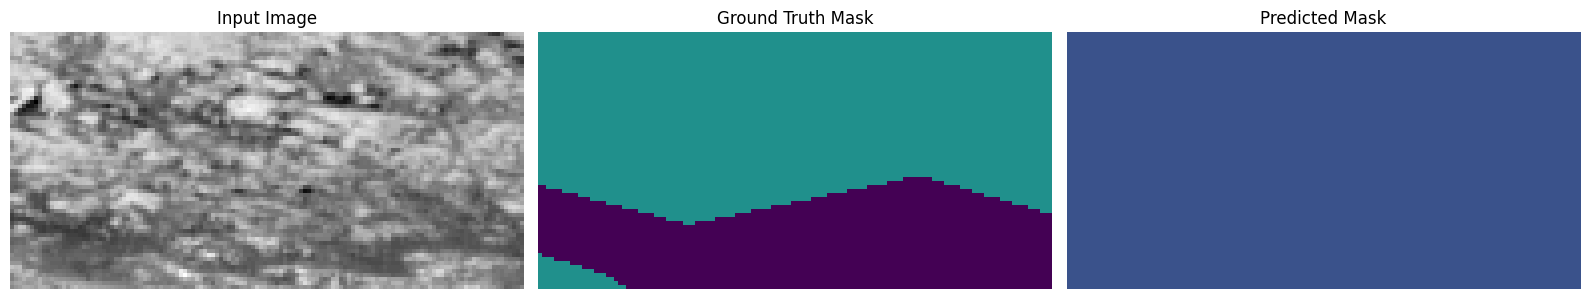

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.4659 - loss: 1.1678 - mean_iou: 0.3156 - val_accuracy: 0.4311 - val_loss: 1.2055 - val_mean_iou: 0.2675
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.4719 - loss: 1.1645 - mean_iou: 0.3290 - val_accuracy: 0.4612 - val_loss: 1.1448 - val_mean_iou: 0.3175
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.4844 - loss: 1.1565 - mean_iou: 0.3401 - val_accuracy: 0.4325 - val_loss: 1.1821 - val_mean_iou: 0.2830
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.4789 - loss: 1.1582 - mean_iou: 0.3466 - val_accuracy: 0.4028 - val_loss: 1.1813 - val_mean_iou: 0.2875
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.4860 - loss: 1.1563 - mean_iou: 0.3593 - val_accuracy: 0.4625 - val_loss: 1.1488 - val_mean_iou: 0.3534
Epoch 61/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4888 - loss: 1.1581 - mean_iou: 0.3599

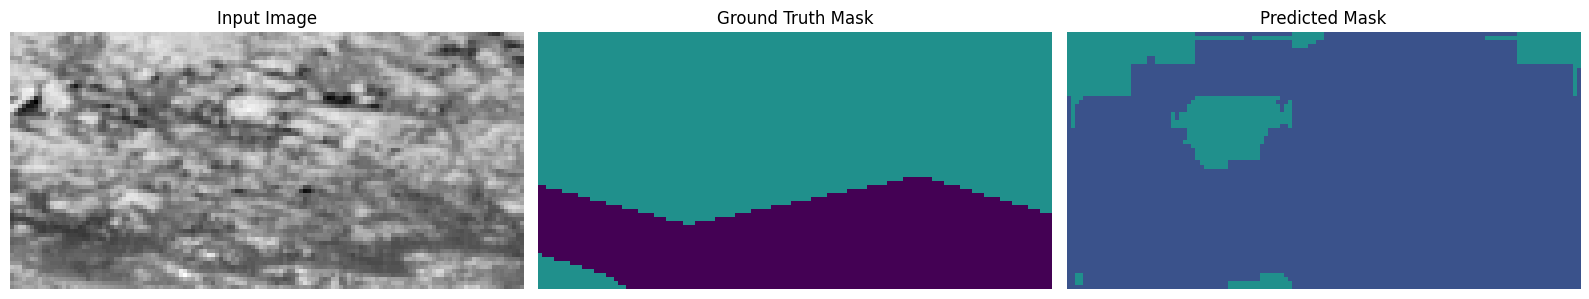

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.4890 - loss: 1.1581 - mean_iou: 0.3603 - val_accuracy: 0.4989 - val_loss: 1.1427 - val_mean_iou: 0.3919
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.5096 - loss: 1.1476 - mean_iou: 0.3846 - val_accuracy: 0.4449 - val_loss: 1.1820 - val_mean_iou: 0.3452
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.5196 - loss: 1.1348 - mean_iou: 0.3980 - val_accuracy: 0.3982 - val_loss: 1.2511 - val_mean_iou: 0.2825
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.5407 - loss: 1.1363 - mean_iou: 0.4157 - val_accuracy: 0.4758 - val_loss: 1.2033 - val_mean_iou: 0.3538
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.5474 - loss: 1.1239 - mean_iou: 0.4298 - val_accuracy: 0.3822 - val_loss: 1.3668 - val_mean_iou: 0.2500
Epoch 66/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5311 - loss: 1.1313 - mean_iou: 0.4101

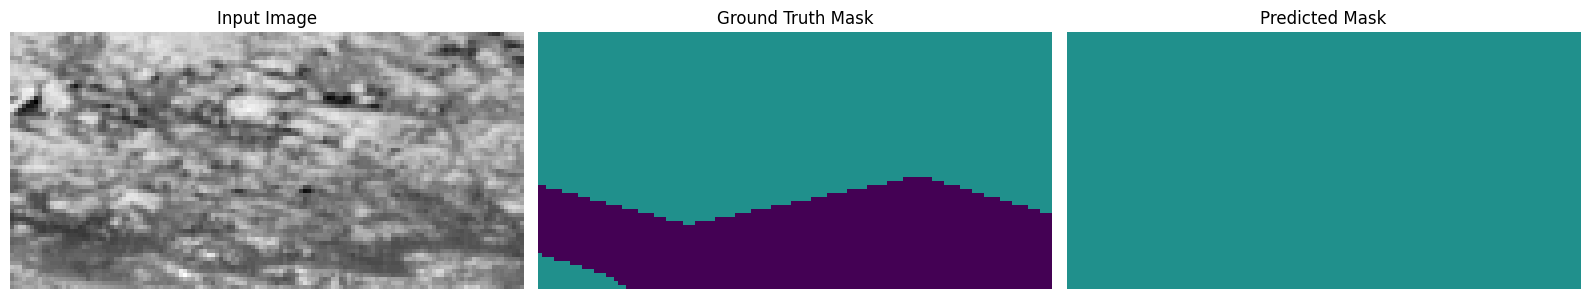

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.5312 - loss: 1.1310 - mean_iou: 0.4104 - val_accuracy: 0.3841 - val_loss: 1.3697 - val_mean_iou: 0.2537
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.5487 - loss: 1.1190 - mean_iou: 0.4313 - val_accuracy: 0.5017 - val_loss: 1.1721 - val_mean_iou: 0.3776
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.5601 - loss: 1.1203 - mean_iou: 0.4399 - val_accuracy: 0.3655 - val_loss: 1.4550 - val_mean_iou: 0.2301
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.5648 - loss: 1.1055 - mean_iou: 0.4461 - val_accuracy: 0.3905 - val_loss: 1.3214 - val_mean_iou: 0.2563
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.5814 - loss: 1.1016 - mean_iou: 0.4665 - val_accuracy: 0.2856 - val_loss: 1.3937 - val_mean_iou: 0.1670
Epoch 71/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5751 - loss: 1.1119 - mean_iou: 0.4591

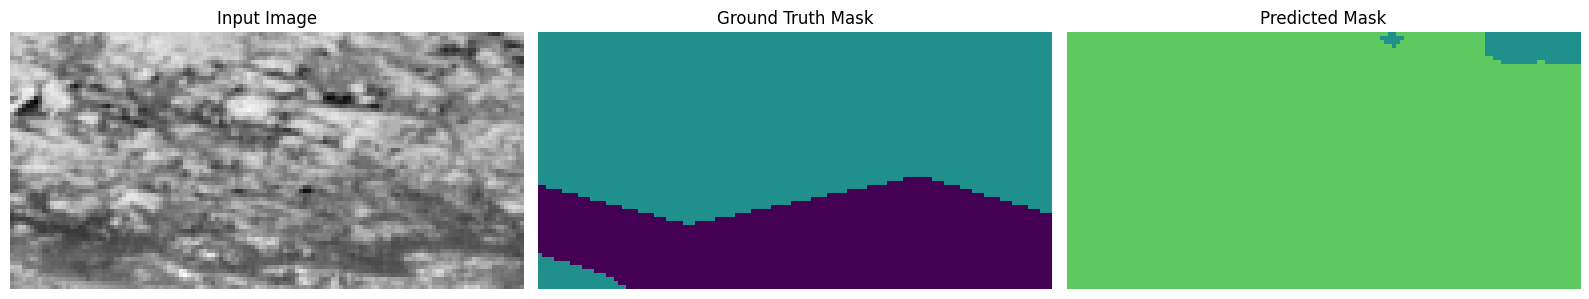

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.5755 - loss: 1.1113 - mean_iou: 0.4596 - val_accuracy: 0.2019 - val_loss: 1.5276 - val_mean_iou: 0.0831
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.5766 - loss: 1.0937 - mean_iou: 0.4630 - val_accuracy: 0.1815 - val_loss: 1.6008 - val_mean_iou: 0.0607
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.5872 - loss: 1.0848 - mean_iou: 0.4782 - val_accuracy: 0.3136 - val_loss: 1.4307 - val_mean_iou: 0.1711
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.5932 - loss: 1.0872 - mean_iou: 0.4791 - val_accuracy: 0.5384 - val_loss: 1.1633 - val_mean_iou: 0.4061
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.5904 - loss: 1.0910 - mean_iou: 0.4792 - val_accuracy: 0.5413 - val_loss: 1.1619 - val_mean_iou: 0.4173
Epoch 76/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5884 - loss: 1.0893 - mean_iou: 0.4763

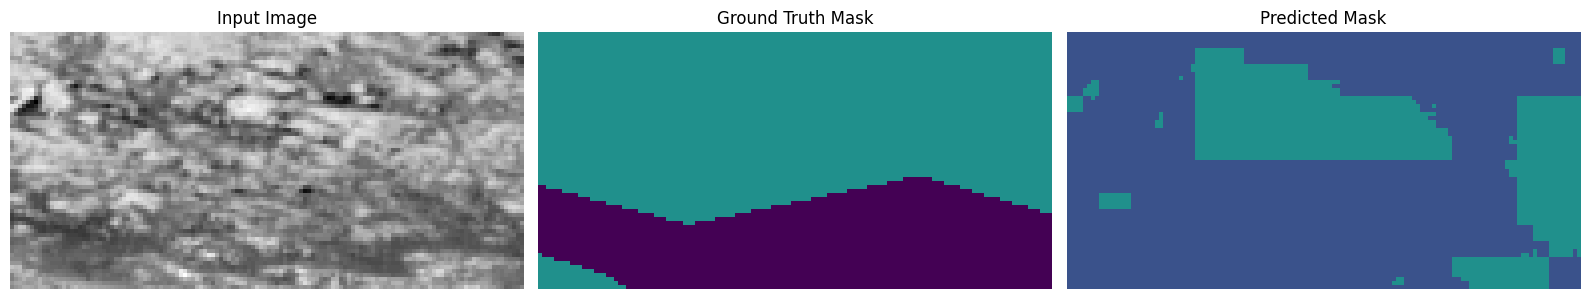

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.5887 - loss: 1.0889 - mean_iou: 0.4767 - val_accuracy: 0.6279 - val_loss: 1.0572 - val_mean_iou: 0.5364
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.5935 - loss: 1.0865 - mean_iou: 0.4813 - val_accuracy: 0.5149 - val_loss: 1.1710 - val_mean_iou: 0.3816
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6106 - loss: 1.0673 - mean_iou: 0.5158 - val_accuracy: 0.5506 - val_loss: 1.1319 - val_mean_iou: 0.4213
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.6033 - loss: 1.0750 - mean_iou: 0.4973 - val_accuracy: 0.5639 - val_loss: 1.1125 - val_mean_iou: 0.4452
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.6061 - loss: 1.0745 - mean_iou: 0.4977 - val_accuracy: 0.5522 - val_loss: 1.1295 - val_mean_iou: 0.4287
Epoch 81/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5990 - loss: 1.0779 - mean_iou: 0.4908

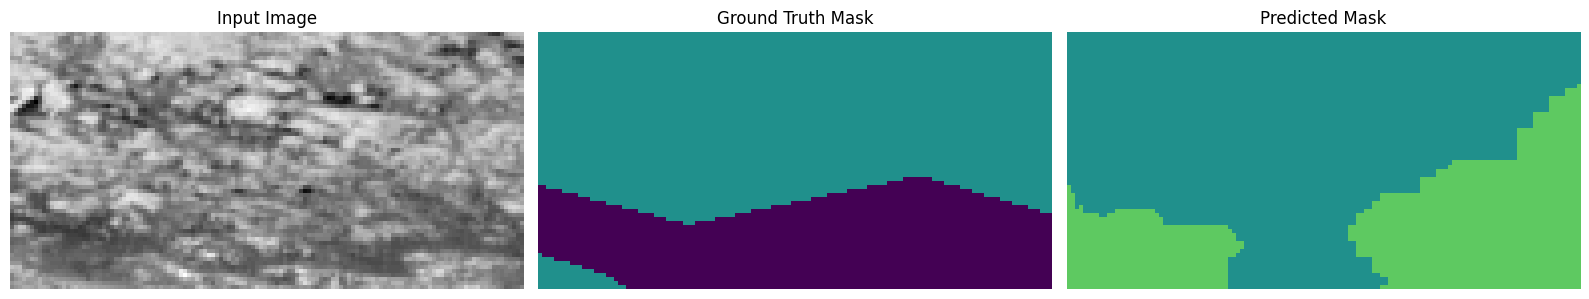

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.5991 - loss: 1.0776 - mean_iou: 0.4910 - val_accuracy: 0.4208 - val_loss: 1.2802 - val_mean_iou: 0.2863
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.5934 - loss: 1.0773 - mean_iou: 0.4821 - val_accuracy: 0.4323 - val_loss: 1.2639 - val_mean_iou: 0.2834
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.5947 - loss: 1.0824 - mean_iou: 0.4807 - val_accuracy: 0.4373 - val_loss: 1.2329 - val_mean_iou: 0.3015
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.5964 - loss: 1.0807 - mean_iou: 0.4842 - val_accuracy: 0.4647 - val_loss: 1.2051 - val_mean_iou: 0.3363
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6058 - loss: 1.0733 - mean_iou: 0.4966 - val_accuracy: 0.5512 - val_loss: 1.1288 - val_mean_iou: 0.4262
Epoch 86/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6096 - loss: 1.0636 - mean_iou: 0.5004

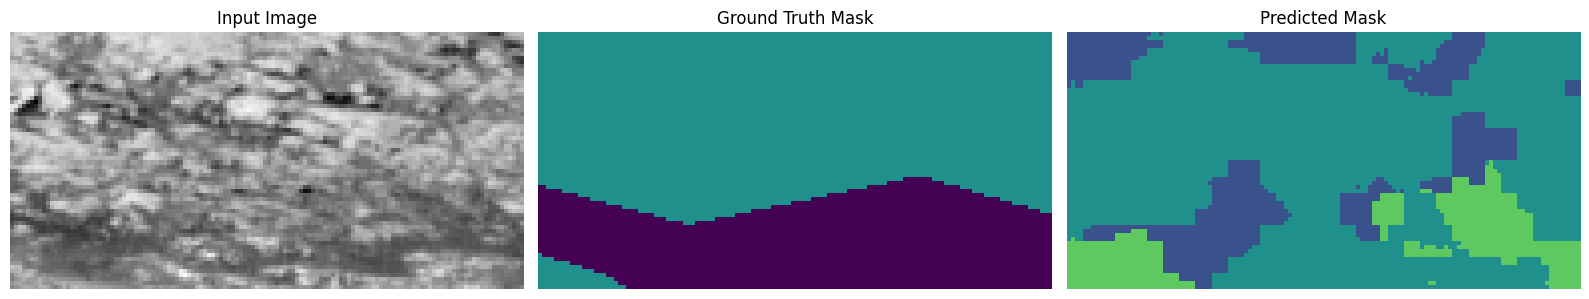

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6098 - loss: 1.0634 - mean_iou: 0.5008 - val_accuracy: 0.5528 - val_loss: 1.1184 - val_mean_iou: 0.4237
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6028 - loss: 1.0665 - mean_iou: 0.4949 - val_accuracy: 0.5872 - val_loss: 1.0973 - val_mean_iou: 0.4828
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6023 - loss: 1.0667 - mean_iou: 0.5001 - val_accuracy: 0.4023 - val_loss: 1.3277 - val_mean_iou: 0.2630
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6138 - loss: 1.0626 - mean_iou: 0.5107 - val_accuracy: 0.5985 - val_loss: 1.0773 - val_mean_iou: 0.4865
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.6174 - loss: 1.0607 - mean_iou: 0.5099 - val_accuracy: 0.6224 - val_loss: 1.0478 - val_mean_iou: 0.5270
Epoch 91/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6047 - loss: 1.0708 - mean_iou: 0.4962

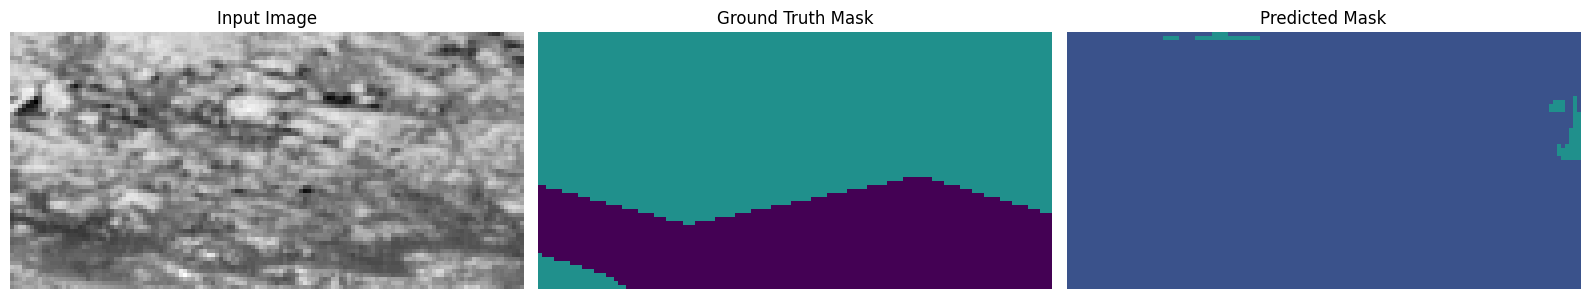

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6051 - loss: 1.0704 - mean_iou: 0.4968 - val_accuracy: 0.5736 - val_loss: 1.0932 - val_mean_iou: 0.4605
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6068 - loss: 1.0611 - mean_iou: 0.5030 - val_accuracy: 0.5970 - val_loss: 1.0952 - val_mean_iou: 0.4796
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.6085 - loss: 1.0619 - mean_iou: 0.4991 - val_accuracy: 0.5845 - val_loss: 1.0963 - val_mean_iou: 0.4755
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.6140 - loss: 1.0607 - mean_iou: 0.5105 - val_accuracy: 0.5974 - val_loss: 1.0848 - val_mean_iou: 0.4888
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6163 - loss: 1.0603 - mean_iou: 0.5147 - val_accuracy: 0.5549 - val_loss: 1.1356 - val_mean_iou: 0.4525
Epoch 96/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6104 - loss: 1.0639 - mean_iou: 0.5061

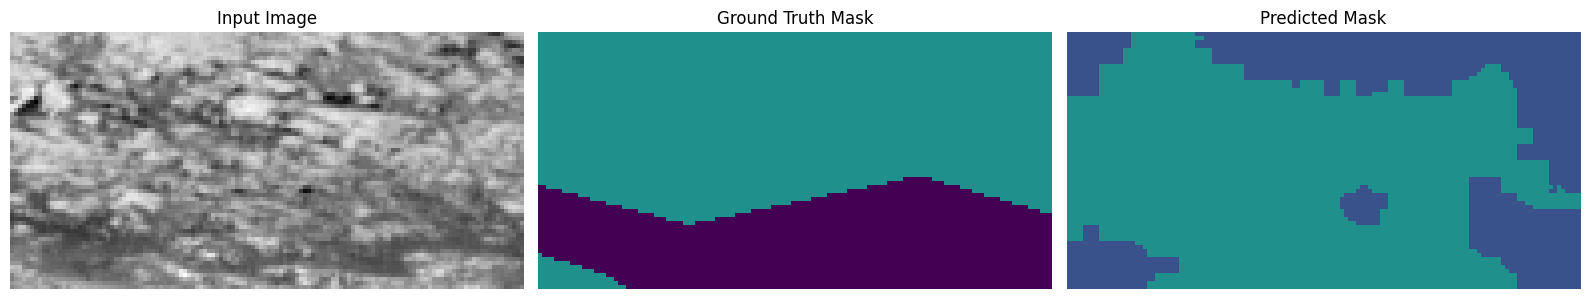

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6108 - loss: 1.0634 - mean_iou: 0.5067 - val_accuracy: 0.6032 - val_loss: 1.0919 - val_mean_iou: 0.4961
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6166 - loss: 1.0631 - mean_iou: 0.5156 - val_accuracy: 0.4765 - val_loss: 1.2380 - val_mean_iou: 0.3285
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6194 - loss: 1.0578 - mean_iou: 0.5187 - val_accuracy: 0.5939 - val_loss: 1.0750 - val_mean_iou: 0.4820
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6274 - loss: 1.0481 - mean_iou: 0.5258 - val_accuracy: 0.5577 - val_loss: 1.1368 - val_mean_iou: 0.4296
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6126 - loss: 1.0620 - mean_iou: 0.5113 - val_accuracy: 0.5531 - val_loss: 1.1491 - val_mean_iou: 0.4174
Epoch 101/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6152 - loss: 1.0577 - mean_iou: 0.5129

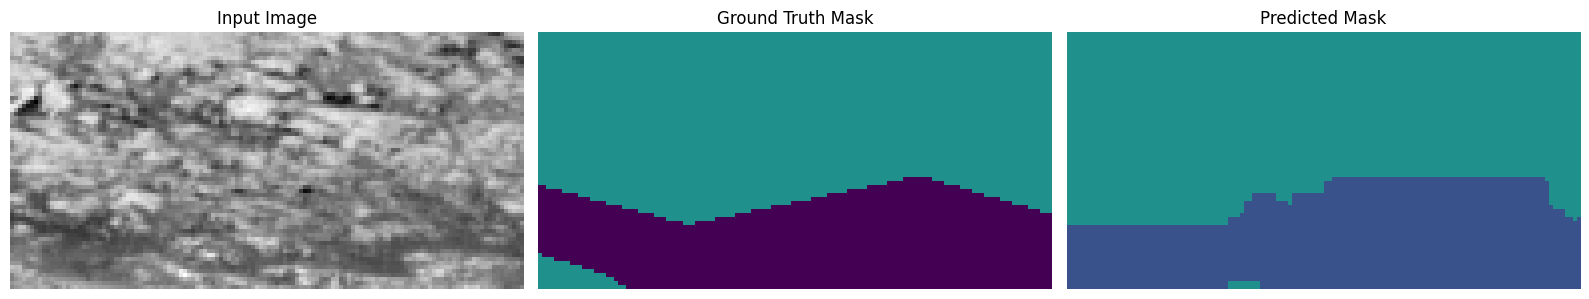

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.6155 - loss: 1.0573 - mean_iou: 0.5134 - val_accuracy: 0.6244 - val_loss: 1.0554 - val_mean_iou: 0.5299
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6315 - loss: 1.0397 - mean_iou: 0.5371 - val_accuracy: 0.6208 - val_loss: 1.0606 - val_mean_iou: 0.5227
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.6120 - loss: 1.0612 - mean_iou: 0.5041 - val_accuracy: 0.6397 - val_loss: 1.0441 - val_mean_iou: 0.5505
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6327 - loss: 1.0452 - mean_iou: 0.5372 - val_accuracy: 0.6289 - val_loss: 1.0538 - val_mean_iou: 0.5364
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6290 - loss: 1.0425 - mean_iou: 0.5305 - val_accuracy: 0.5575 - val_loss: 1.1544 - val_mean_iou: 0.4236
Epoch 106/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6292 - loss: 1.0464 - mean_iou: 0.5272

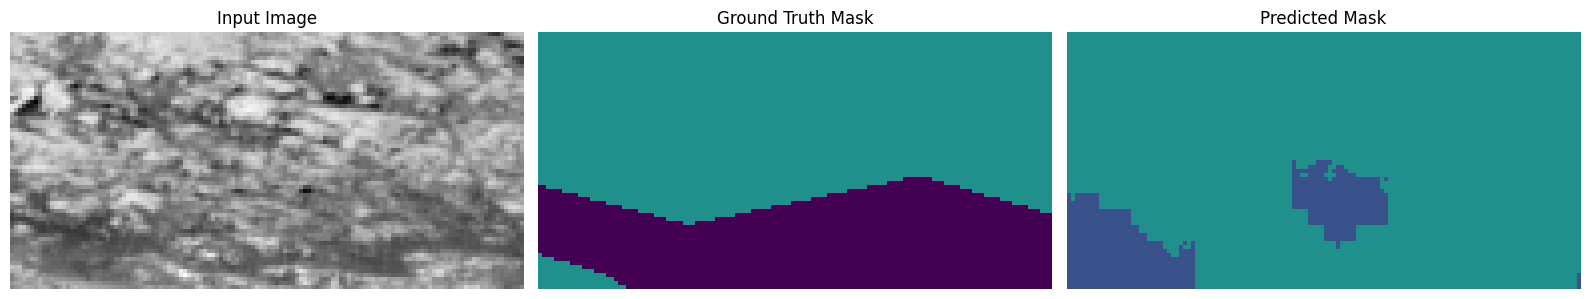

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.6291 - loss: 1.0464 - mean_iou: 0.5273 - val_accuracy: 0.6411 - val_loss: 1.0584 - val_mean_iou: 0.5546
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6266 - loss: 1.0537 - mean_iou: 0.5267 - val_accuracy: 0.6199 - val_loss: 1.0444 - val_mean_iou: 0.5231
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6234 - loss: 1.0509 - mean_iou: 0.5273 - val_accuracy: 0.4967 - val_loss: 1.1779 - val_mean_iou: 0.3489
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.6178 - loss: 1.0600 - mean_iou: 0.5138 - val_accuracy: 0.5940 - val_loss: 1.0845 - val_mean_iou: 0.4804
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6183 - loss: 1.0579 - mean_iou: 0.5212 - val_accuracy: 0.5727 - val_loss: 1.1050 - val_mean_iou: 0.4500
Epoch 111/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6309 - loss: 1.0397 - mean_iou: 0.5432

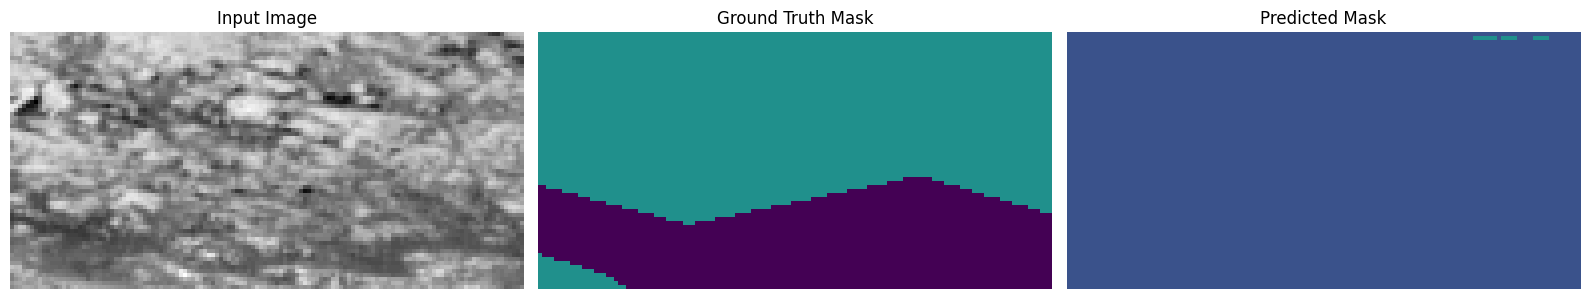

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6310 - loss: 1.0396 - mean_iou: 0.5432 - val_accuracy: 0.5917 - val_loss: 1.0798 - val_mean_iou: 0.4797
Epoch 112/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6273 - loss: 1.0450 - mean_iou: 0.5287 - val_accuracy: 0.6048 - val_loss: 1.0756 - val_mean_iou: 0.4991
Epoch 113/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6391 - loss: 1.0351 - mean_iou: 0.5436 - val_accuracy: 0.5982 - val_loss: 1.0905 - val_mean_iou: 0.4904
Epoch 114/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6379 - loss: 1.0404 - mean_iou: 0.5394 - val_accuracy: 0.6168 - val_loss: 1.0629 - val_mean_iou: 0.5161
Epoch 115/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6301 - loss: 1.0457 - mean_iou: 0.5356 - val_accuracy: 0.5587 - val_loss: 1.1078 - val_mean_iou: 0.4571
Epoch 116/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6307 - loss: 1.0460 - mean_iou: 0.5319

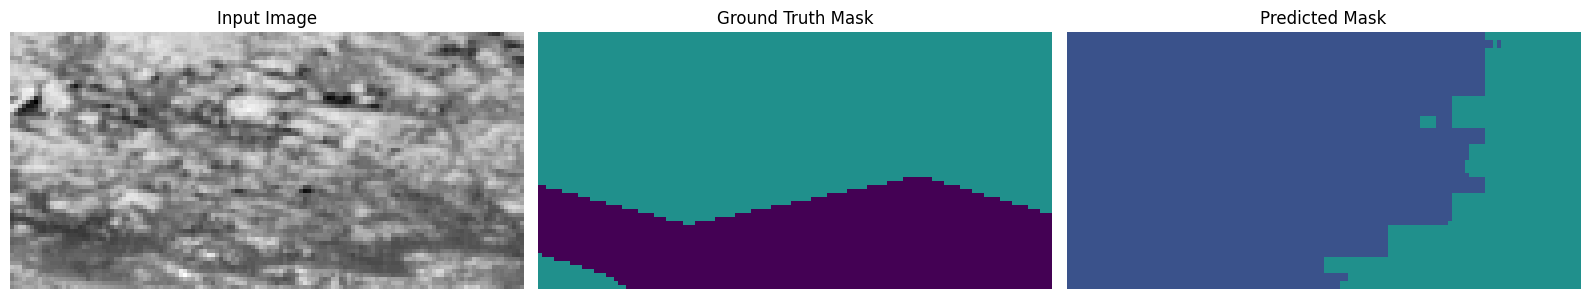

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.6307 - loss: 1.0460 - mean_iou: 0.5320 - val_accuracy: 0.5799 - val_loss: 1.0994 - val_mean_iou: 0.4656
Epoch 117/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.6291 - loss: 1.0477 - mean_iou: 0.5343 - val_accuracy: 0.6507 - val_loss: 1.0331 - val_mean_iou: 0.5662
Epoch 118/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.6188 - loss: 1.0554 - mean_iou: 0.5235 - val_accuracy: 0.5950 - val_loss: 1.0803 - val_mean_iou: 0.4890
Epoch 119/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6273 - loss: 1.0506 - mean_iou: 0.5295 - val_accuracy: 0.5945 - val_loss: 1.0584 - val_mean_iou: 0.4877
Epoch 120/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6358 - loss: 1.0366 - mean_iou: 0.5379 - val_accuracy: 0.6181 - val_loss: 1.0515 - val_mean_iou: 0.5188
Epoch 121/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6444 - loss: 1.0338 - mean_iou: 0.5537

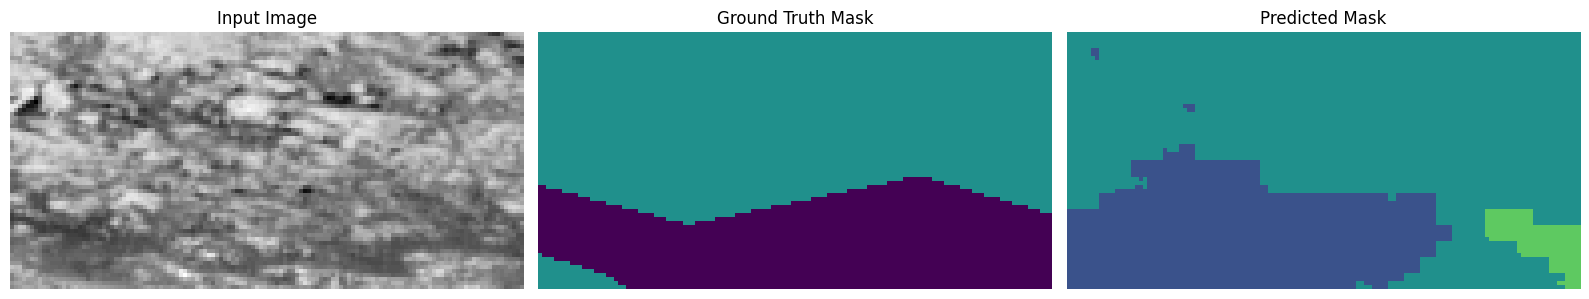

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.6443 - loss: 1.0338 - mean_iou: 0.5536 - val_accuracy: 0.6179 - val_loss: 1.0690 - val_mean_iou: 0.5110
Epoch 122/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6397 - loss: 1.0368 - mean_iou: 0.5391 - val_accuracy: 0.6415 - val_loss: 1.0398 - val_mean_iou: 0.5519
Epoch 123/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6341 - loss: 1.0400 - mean_iou: 0.5356 - val_accuracy: 0.6611 - val_loss: 1.0148 - val_mean_iou: 0.5823
Epoch 124/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6353 - loss: 1.0358 - mean_iou: 0.5450 - val_accuracy: 0.6397 - val_loss: 1.0380 - val_mean_iou: 0.5511
Epoch 125/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6344 - loss: 1.0441 - mean_iou: 0.5310 - val_accuracy: 0.6529 - val_loss: 1.0230 - val_mean_iou: 0.5702
Epoch 126/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6361 - loss: 1.0364 - mean_iou: 0.5421

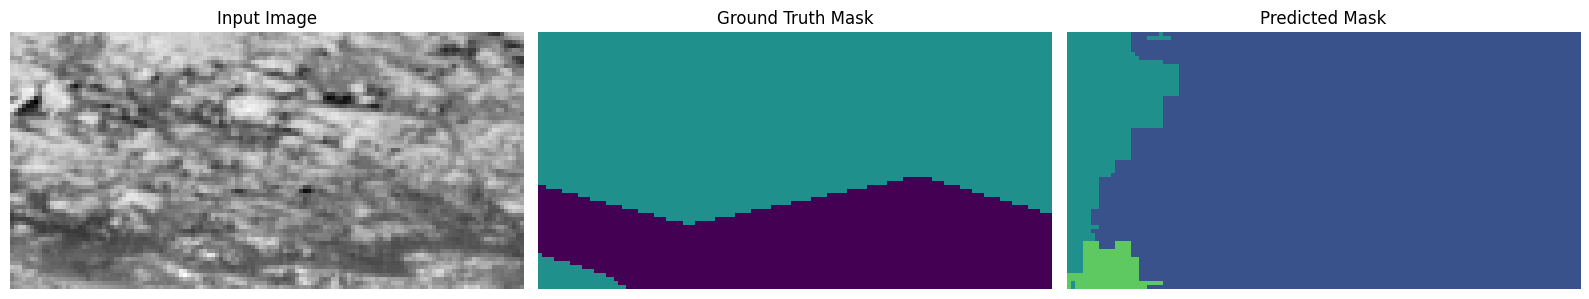

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6364 - loss: 1.0361 - mean_iou: 0.5425 - val_accuracy: 0.5396 - val_loss: 1.1390 - val_mean_iou: 0.4037
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6362 - loss: 1.0428 - mean_iou: 0.5350 - val_accuracy: 0.6155 - val_loss: 1.0575 - val_mean_iou: 0.5106
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6471 - loss: 1.0269 - mean_iou: 0.5577 - val_accuracy: 0.6025 - val_loss: 1.0851 - val_mean_iou: 0.4889
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.6328 - loss: 1.0348 - mean_iou: 0.5379 - val_accuracy: 0.4777 - val_loss: 1.2027 - val_mean_iou: 0.3474
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.6452 - loss: 1.0328 - mean_iou: 0.5545 - val_accuracy: 0.6026 - val_loss: 1.0817 - val_mean_iou: 0.4985
Epoch 131/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6428 - loss: 1.0266 - mean_iou: 0.5534

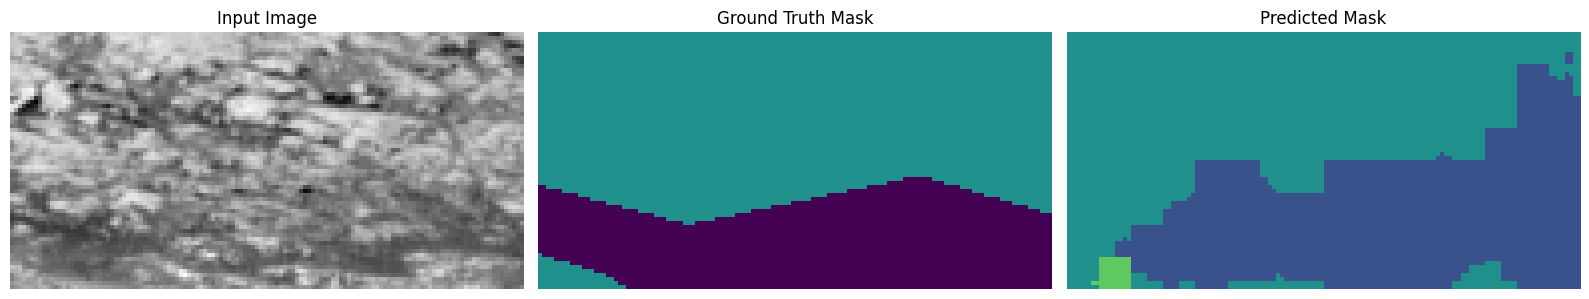

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6429 - loss: 1.0265 - mean_iou: 0.5536 - val_accuracy: 0.6374 - val_loss: 1.0403 - val_mean_iou: 0.5439
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.6378 - loss: 1.0393 - mean_iou: 0.5414 - val_accuracy: 0.6351 - val_loss: 1.0448 - val_mean_iou: 0.5406
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6399 - loss: 1.0332 - mean_iou: 0.5433 - val_accuracy: 0.6245 - val_loss: 1.0482 - val_mean_iou: 0.5198
Epoch 134/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6462 - loss: 1.0301 - mean_iou: 0.5494 - val_accuracy: 0.5876 - val_loss: 1.0941 - val_mean_iou: 0.4646
Epoch 135/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6367 - loss: 1.0382 - mean_iou: 0.5464 - val_accuracy: 0.4876 - val_loss: 1.1807 - val_mean_iou: 0.3800
Epoch 136/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6422 - loss: 1.0293 - mean_iou: 0.5526

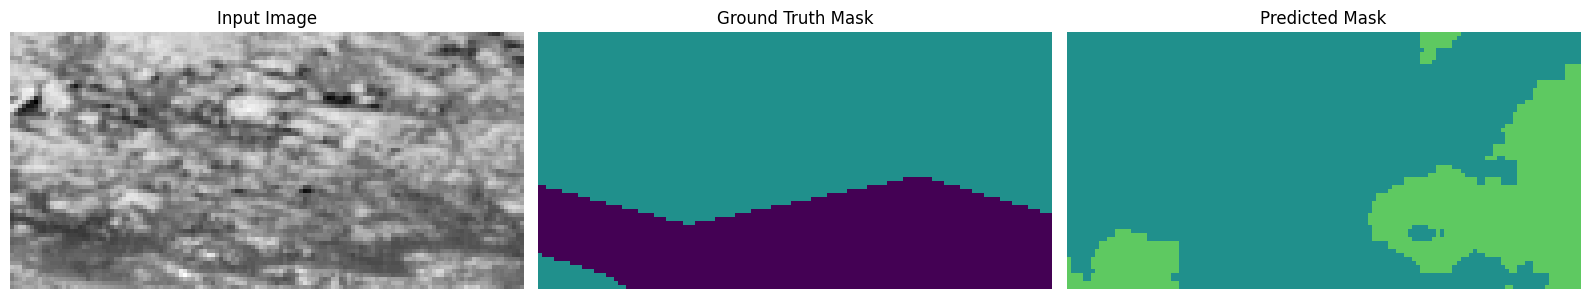

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.6425 - loss: 1.0290 - mean_iou: 0.5530 - val_accuracy: 0.5009 - val_loss: 1.1630 - val_mean_iou: 0.3806
Epoch 137/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.6452 - loss: 1.0320 - mean_iou: 0.5491 - val_accuracy: 0.6556 - val_loss: 1.0185 - val_mean_iou: 0.5729
Epoch 138/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.6493 - loss: 1.0269 - mean_iou: 0.5564 - val_accuracy: 0.5063 - val_loss: 1.1670 - val_mean_iou: 0.3857
Epoch 139/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6366 - loss: 1.0334 - mean_iou: 0.5395 - val_accuracy: 0.4229 - val_loss: 1.2790 - val_mean_iou: 0.2958
Epoch 140/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6455 - loss: 1.0251 - mean_iou: 0.5582 - val_accuracy: 0.5036 - val_loss: 1.1820 - val_mean_iou: 0.3802
Epoch 141/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6471 - loss: 1.0243 - mean_iou: 0.5536

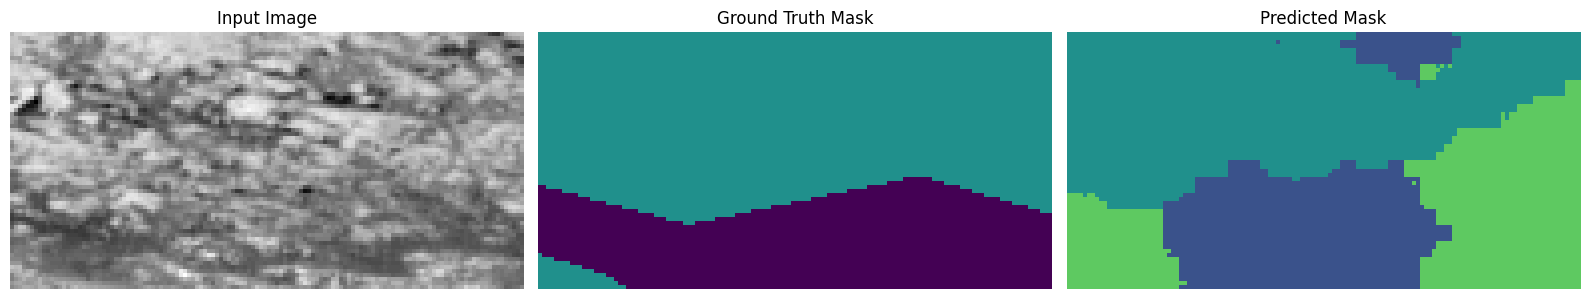

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.6471 - loss: 1.0242 - mean_iou: 0.5538 - val_accuracy: 0.5453 - val_loss: 1.1382 - val_mean_iou: 0.4268
Epoch 142/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.6433 - loss: 1.0295 - mean_iou: 0.5563 - val_accuracy: 0.4476 - val_loss: 1.2366 - val_mean_iou: 0.3175
Epoch 143/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6468 - loss: 1.0271 - mean_iou: 0.5534 - val_accuracy: 0.3811 - val_loss: 1.3717 - val_mean_iou: 0.2442
Epoch 144/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6539 - loss: 1.0161 - mean_iou: 0.5674 - val_accuracy: 0.4834 - val_loss: 1.1915 - val_mean_iou: 0.3626
Epoch 145/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6448 - loss: 1.0229 - mean_iou: 0.5535 - val_accuracy: 0.5245 - val_loss: 1.1579 - val_mean_iou: 0.3927
Epoch 146/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6448 - loss: 1.0236 - mean_iou: 0.5518

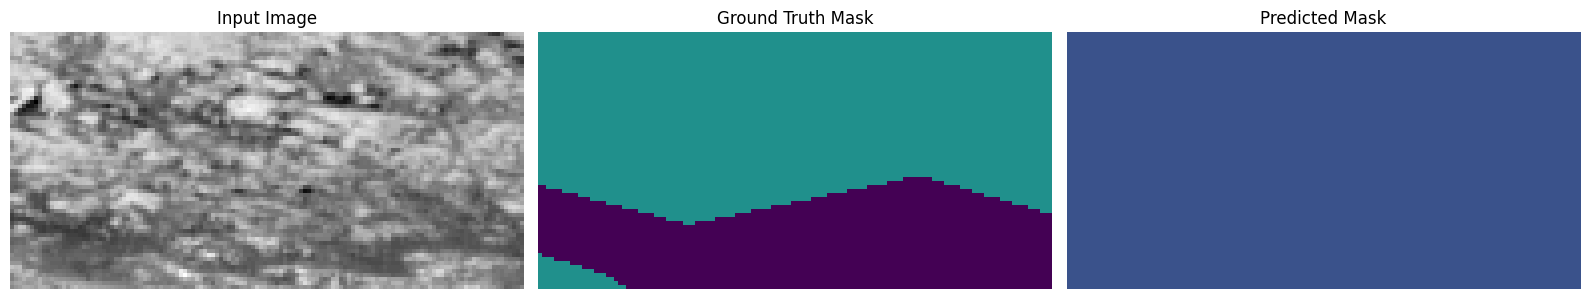

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6450 - loss: 1.0234 - mean_iou: 0.5523 - val_accuracy: 0.6105 - val_loss: 1.0719 - val_mean_iou: 0.5082
Epoch 147/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.6621 - loss: 1.0114 - mean_iou: 0.5764 - val_accuracy: 0.5896 - val_loss: 1.0959 - val_mean_iou: 0.4813
Epoch 148/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.6457 - loss: 1.0224 - mean_iou: 0.5564 - val_accuracy: 0.5876 - val_loss: 1.0998 - val_mean_iou: 0.4727
Epoch 149/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.6555 - loss: 1.0212 - mean_iou: 0.5622 - val_accuracy: 0.6670 - val_loss: 1.0110 - val_mean_iou: 0.5931
Epoch 150/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6504 - loss: 1.0171 - mean_iou: 0.5654 - val_accuracy: 0.5096 - val_loss: 1.1815 - val_mean_iou: 0.3835
Epoch 151/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6535 - loss: 1.0165 - mean_iou: 0.5695

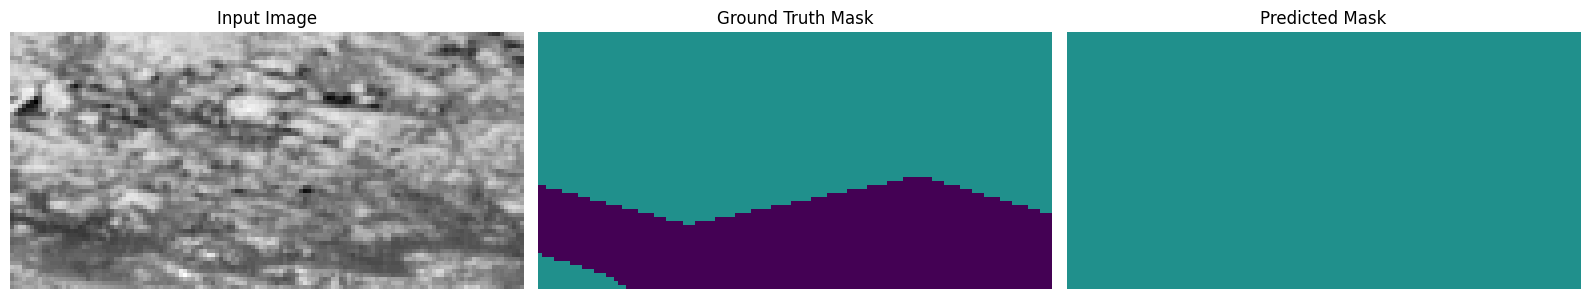

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6535 - loss: 1.0165 - mean_iou: 0.5694 - val_accuracy: 0.6695 - val_loss: 1.0068 - val_mean_iou: 0.5934
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6482 - loss: 1.0252 - mean_iou: 0.5573 - val_accuracy: 0.6658 - val_loss: 1.0092 - val_mean_iou: 0.5910
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6443 - loss: 1.0285 - mean_iou: 0.5530 - val_accuracy: 0.6344 - val_loss: 1.0279 - val_mean_iou: 0.5504
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6483 - loss: 1.0259 - mean_iou: 0.5575 - val_accuracy: 0.5873 - val_loss: 1.0827 - val_mean_iou: 0.4784
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6614 - loss: 1.0123 - mean_iou: 0.5781 - val_accuracy: 0.6379 - val_loss: 1.0408 - val_mean_iou: 0.5547
Epoch 156/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6619 - loss: 1.0151 - mean_iou: 0.5884

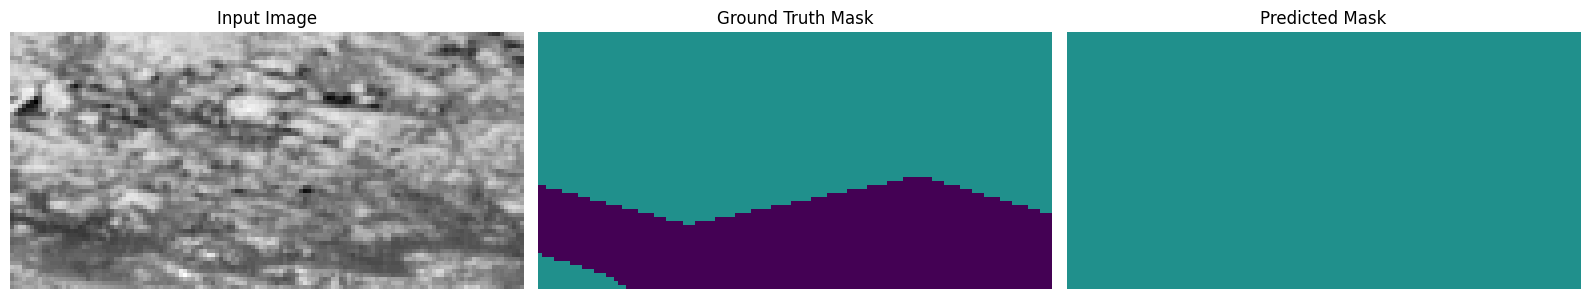

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6618 - loss: 1.0150 - mean_iou: 0.5881 - val_accuracy: 0.6626 - val_loss: 1.0155 - val_mean_iou: 0.5903
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.6533 - loss: 1.0188 - mean_iou: 0.5691 - val_accuracy: 0.6146 - val_loss: 1.0575 - val_mean_iou: 0.5237
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6520 - loss: 1.0145 - mean_iou: 0.5658 - val_accuracy: 0.6194 - val_loss: 1.0399 - val_mean_iou: 0.5225
Epoch 159/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6562 - loss: 1.0142 - mean_iou: 0.5700 - val_accuracy: 0.6102 - val_loss: 1.0510 - val_mean_iou: 0.5085
Epoch 160/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6667 - loss: 1.0078 - mean_iou: 0.5874 - val_accuracy: 0.6722 - val_loss: 0.9924 - val_mean_iou: 0.6005
Epoch 161/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6594 - loss: 1.0094 - mean_iou: 0.5812

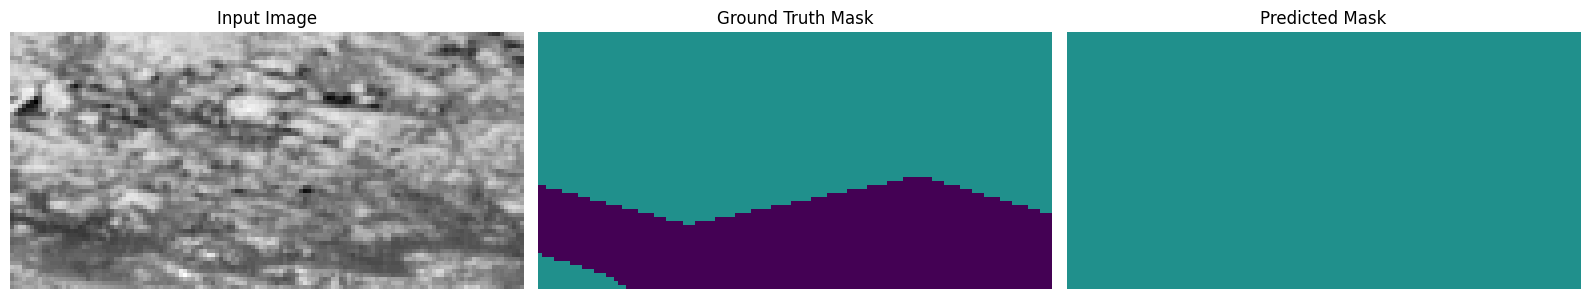

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6595 - loss: 1.0094 - mean_iou: 0.5811 - val_accuracy: 0.6680 - val_loss: 0.9998 - val_mean_iou: 0.5947
Epoch 162/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.6679 - loss: 1.0029 - mean_iou: 0.5902 - val_accuracy: 0.6644 - val_loss: 1.0101 - val_mean_iou: 0.5862
Epoch 163/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 352ms/step - accuracy: 0.6581 - loss: 1.0106 - mean_iou: 0.5722 - val_accuracy: 0.6622 - val_loss: 1.0170 - val_mean_iou: 0.5862
Epoch 164/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.6592 - loss: 1.0139 - mean_iou: 0.5754 - val_accuracy: 0.6595 - val_loss: 1.0059 - val_mean_iou: 0.5830
Epoch 165/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.6587 - loss: 1.0153 - mean_iou: 0.5742 - val_accuracy: 0.6613 - val_loss: 1.0129 - val_mean_iou: 0.5811
Epoch 166/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6656 - loss: 1.0093 - mean_iou: 0.5838

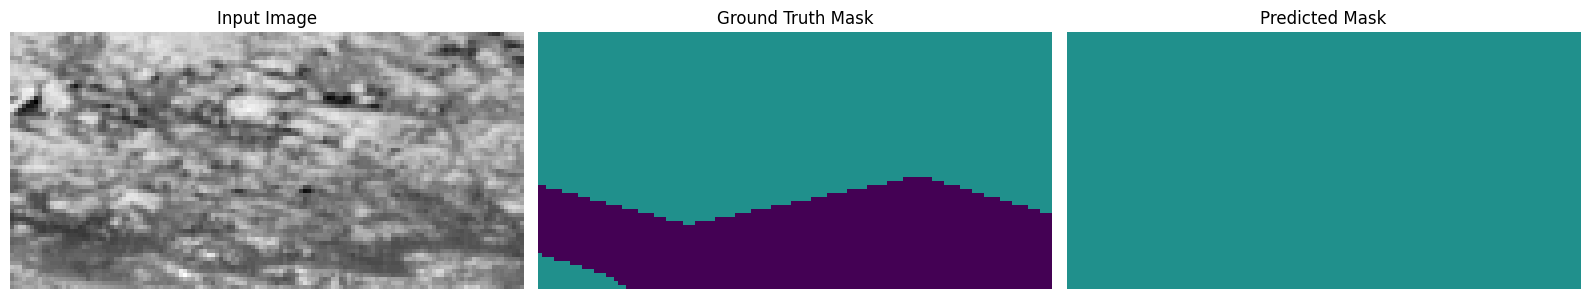

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.6656 - loss: 1.0091 - mean_iou: 0.5839 - val_accuracy: 0.6671 - val_loss: 1.0057 - val_mean_iou: 0.5891
Epoch 167/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6637 - loss: 1.0052 - mean_iou: 0.5832 - val_accuracy: 0.6667 - val_loss: 0.9983 - val_mean_iou: 0.5949
Epoch 168/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.6590 - loss: 1.0141 - mean_iou: 0.5738 - val_accuracy: 0.6212 - val_loss: 1.0384 - val_mean_iou: 0.5374
Epoch 169/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.6626 - loss: 1.0065 - mean_iou: 0.5822 - val_accuracy: 0.5923 - val_loss: 1.0606 - val_mean_iou: 0.5007
Epoch 170/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.6600 - loss: 1.0154 - mean_iou: 0.5705 - val_accuracy: 0.6399 - val_loss: 1.0191 - val_mean_iou: 0.5615
Epoch 171/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6596 - loss: 1.0122 - mean_iou: 0.5805

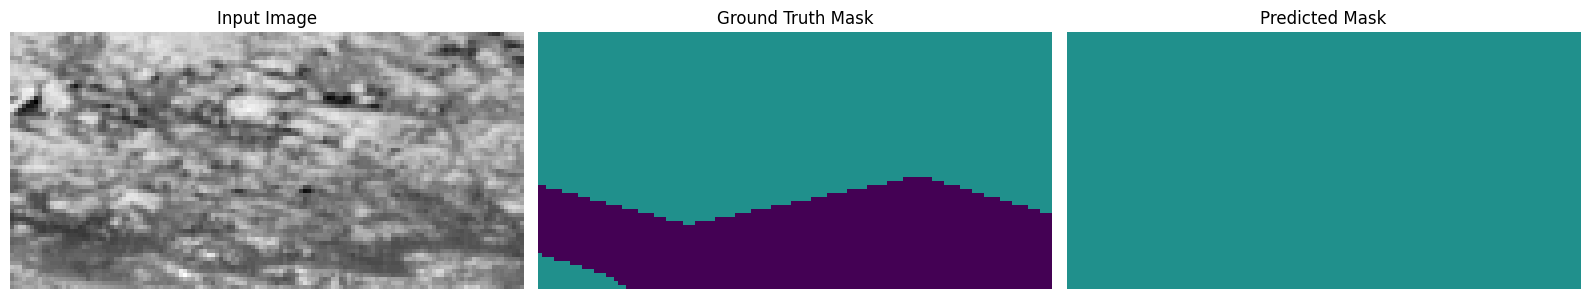

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.6595 - loss: 1.0120 - mean_iou: 0.5805 - val_accuracy: 0.6488 - val_loss: 1.0085 - val_mean_iou: 0.5741
Epoch 172/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.6787 - loss: 0.9941 - mean_iou: 0.6036 - val_accuracy: 0.6146 - val_loss: 1.0526 - val_mean_iou: 0.5232
Epoch 173/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6657 - loss: 1.0055 - mean_iou: 0.5836 - val_accuracy: 0.6300 - val_loss: 1.0375 - val_mean_iou: 0.5349
Epoch 174/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6605 - loss: 1.0110 - mean_iou: 0.5825 - val_accuracy: 0.6005 - val_loss: 1.0753 - val_mean_iou: 0.4841
Epoch 175/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6754 - loss: 0.9961 - mean_iou: 0.5993 - val_accuracy: 0.6123 - val_loss: 1.0584 - val_mean_iou: 0.5046
Epoch 176/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6649 - loss: 1.0031 - mean_iou: 0.5837

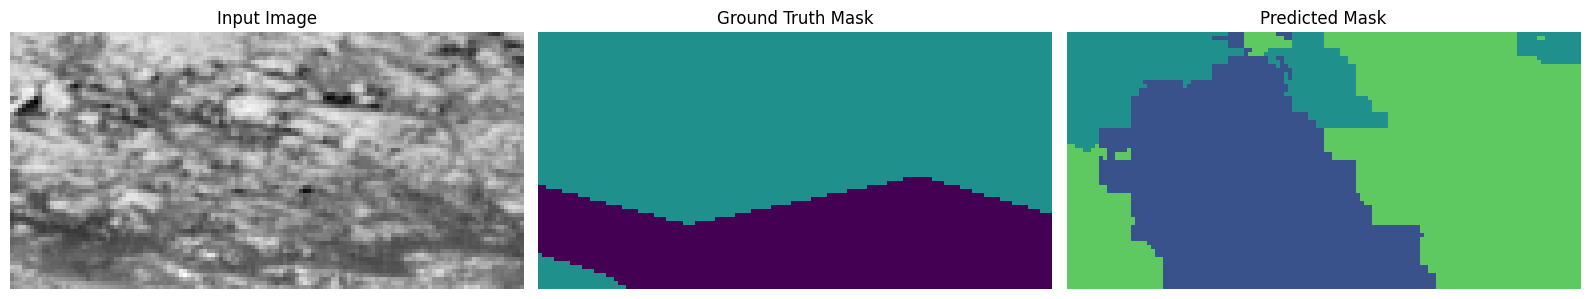

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.6649 - loss: 1.0031 - mean_iou: 0.5838 - val_accuracy: 0.4577 - val_loss: 1.2325 - val_mean_iou: 0.3192
Epoch 177/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6623 - loss: 1.0067 - mean_iou: 0.5821 - val_accuracy: 0.5500 - val_loss: 1.1206 - val_mean_iou: 0.4301
Epoch 178/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6677 - loss: 0.9988 - mean_iou: 0.5903 - val_accuracy: 0.6121 - val_loss: 1.0607 - val_mean_iou: 0.5096
Epoch 179/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - accuracy: 0.6682 - loss: 1.0023 - mean_iou: 0.5839 - val_accuracy: 0.6006 - val_loss: 1.0810 - val_mean_iou: 0.4997
Epoch 180/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.6627 - loss: 1.0067 - mean_iou: 0.5804 - val_accuracy: 0.6688 - val_loss: 0.9990 - val_mean_iou: 0.5945
Epoch 181/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6715 - loss: 1.0017 - mean_iou: 0.5942

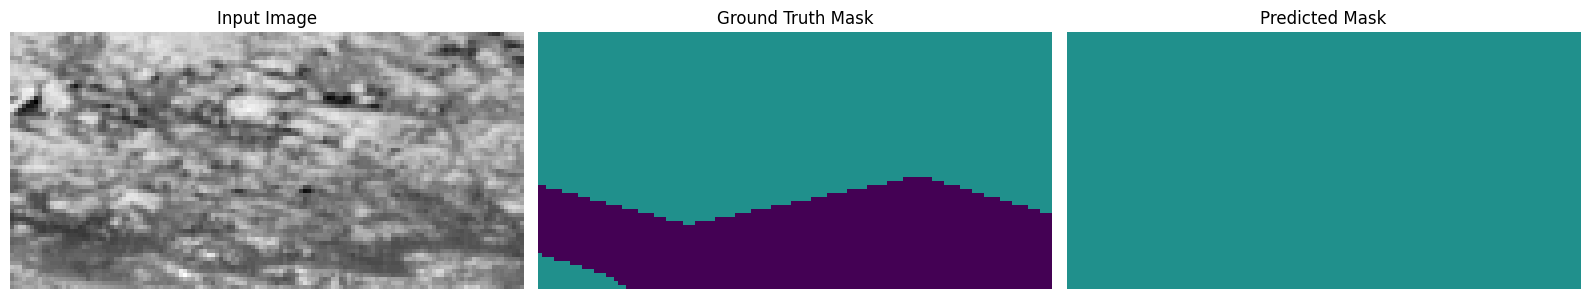

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.6715 - loss: 1.0016 - mean_iou: 0.5943 - val_accuracy: 0.6686 - val_loss: 1.0024 - val_mean_iou: 0.5925
Epoch 182/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6757 - loss: 0.9969 - mean_iou: 0.5973 - val_accuracy: 0.6612 - val_loss: 1.0147 - val_mean_iou: 0.5865
Epoch 183/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.6729 - loss: 0.9947 - mean_iou: 0.5963 - val_accuracy: 0.5267 - val_loss: 1.1685 - val_mean_iou: 0.4252
Epoch 184/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6693 - loss: 1.0032 - mean_iou: 0.5926 - val_accuracy: 0.5785 - val_loss: 1.0974 - val_mean_iou: 0.4770
Epoch 185/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.6687 - loss: 1.0051 - mean_iou: 0.5879 - val_accuracy: 0.6412 - val_loss: 1.0301 - val_mean_iou: 0.5605
Epoch 186/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6695 - loss: 1.0002 - mean_iou: 0.5899

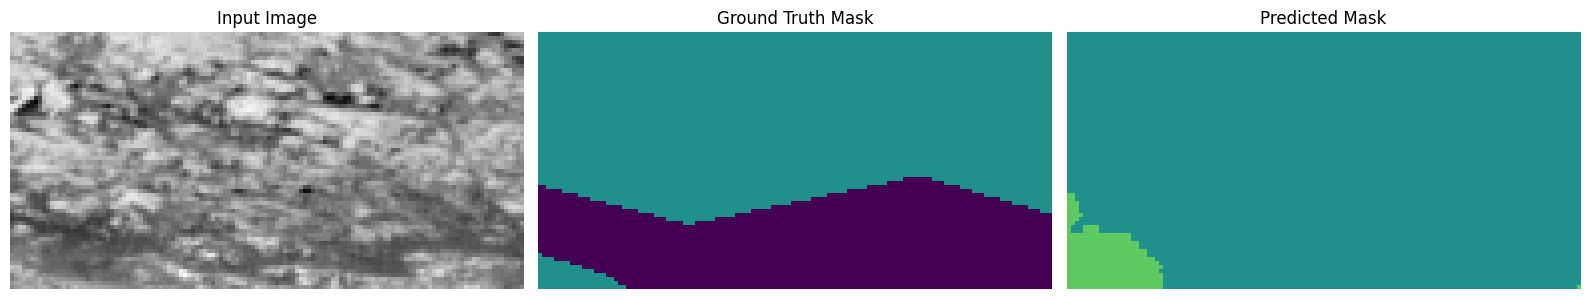

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.6694 - loss: 1.0002 - mean_iou: 0.5899 - val_accuracy: 0.6065 - val_loss: 1.0701 - val_mean_iou: 0.5015
Epoch 187/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.6701 - loss: 0.9999 - mean_iou: 0.5964 - val_accuracy: 0.6361 - val_loss: 1.0278 - val_mean_iou: 0.5565
Epoch 188/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.6685 - loss: 1.0053 - mean_iou: 0.5873 - val_accuracy: 0.6450 - val_loss: 1.0213 - val_mean_iou: 0.5662
Epoch 189/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.6693 - loss: 0.9998 - mean_iou: 0.5921 - val_accuracy: 0.6661 - val_loss: 1.0009 - val_mean_iou: 0.5903
Epoch 190/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.6720 - loss: 0.9997 - mean_iou: 0.5937 - val_accuracy: 0.6463 - val_loss: 1.0294 - val_mean_iou: 0.5615
Final validation Mean Intersection Over Union: 60.05%


In [21]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

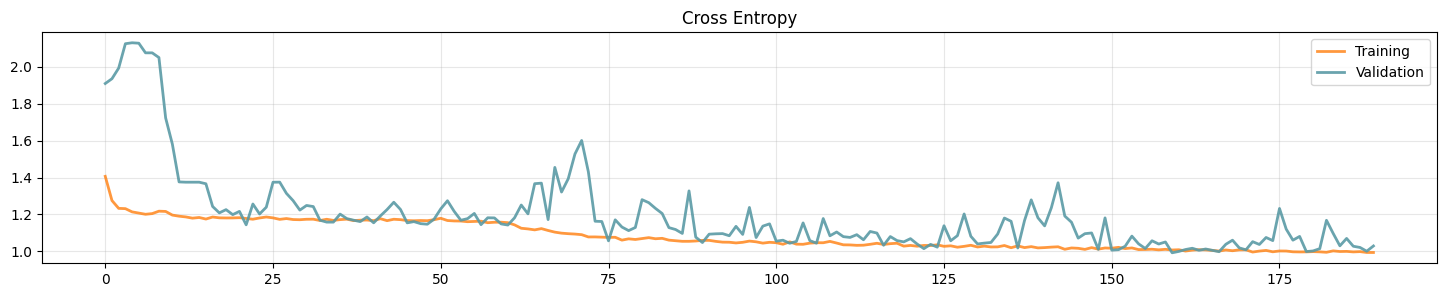

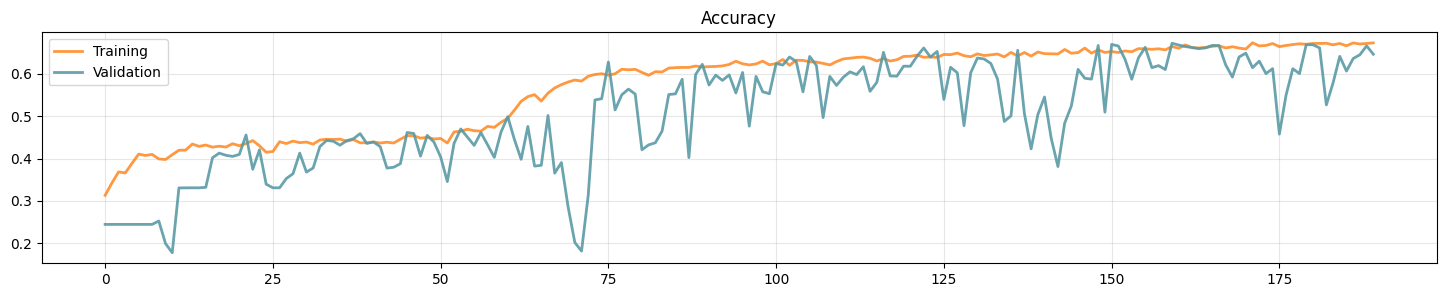

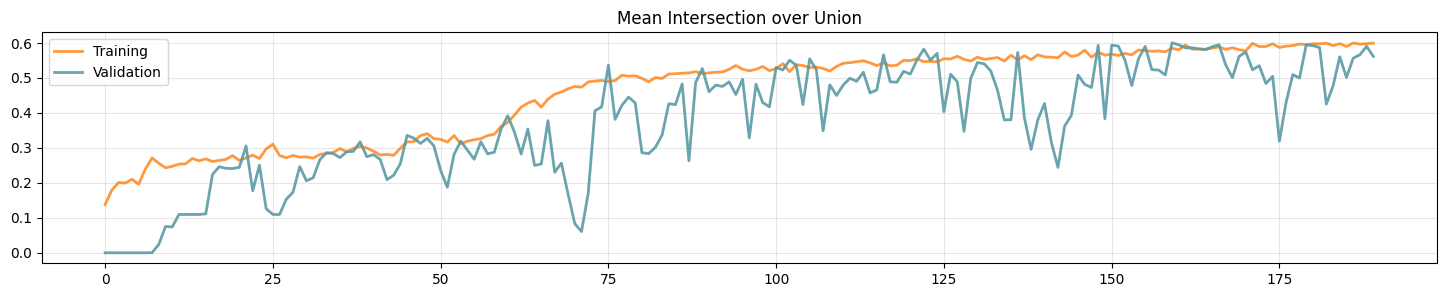

In [22]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [23]:
# If model_filename is not defined, load the most recent model from Google Drive
# if "model_filename" not in globals() or model_filename is None:
#     files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#     files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#     if files:
#         model_filename = files[0]
#     else:
#         raise FileNotFoundError("No model files found in the current directory.")

In [24]:
# model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_60.05.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 879ms/step
(300, 64, 128, 5)
Predictions shape: (300, 64, 128)


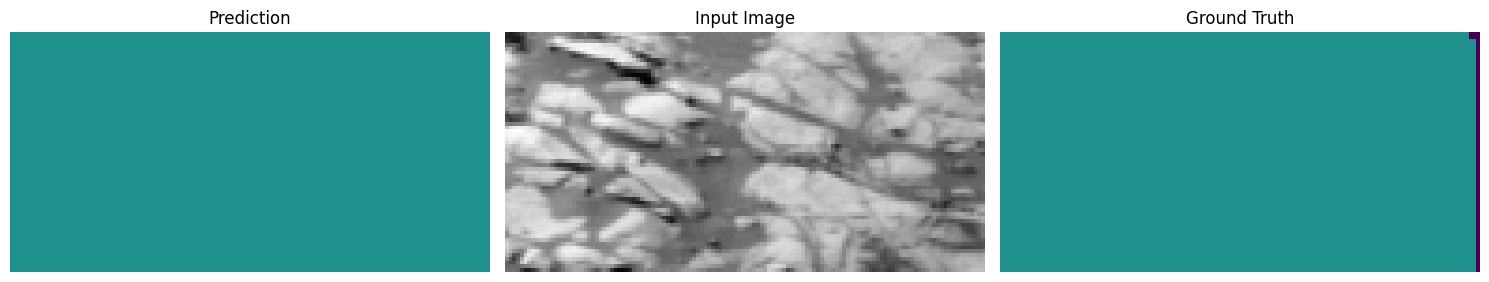

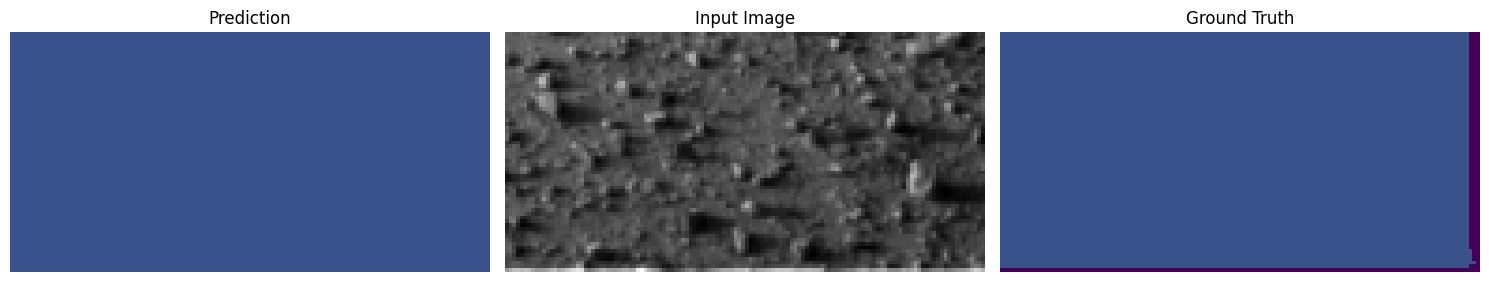

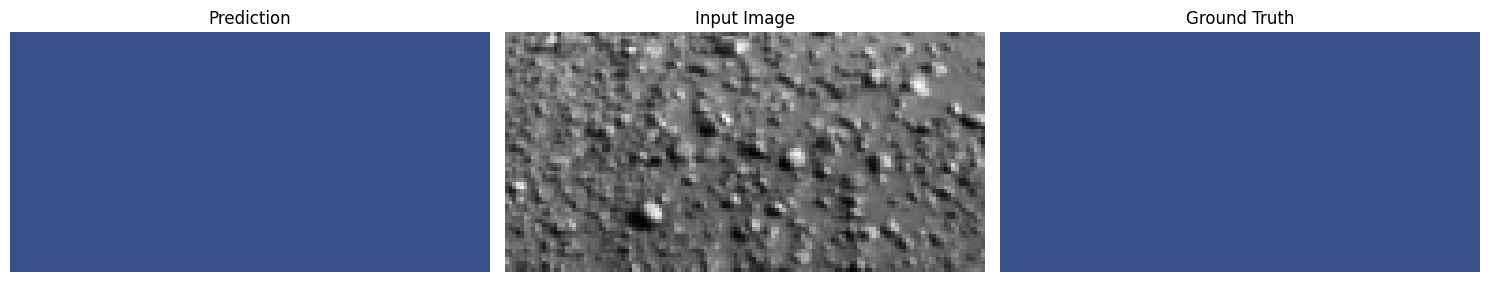

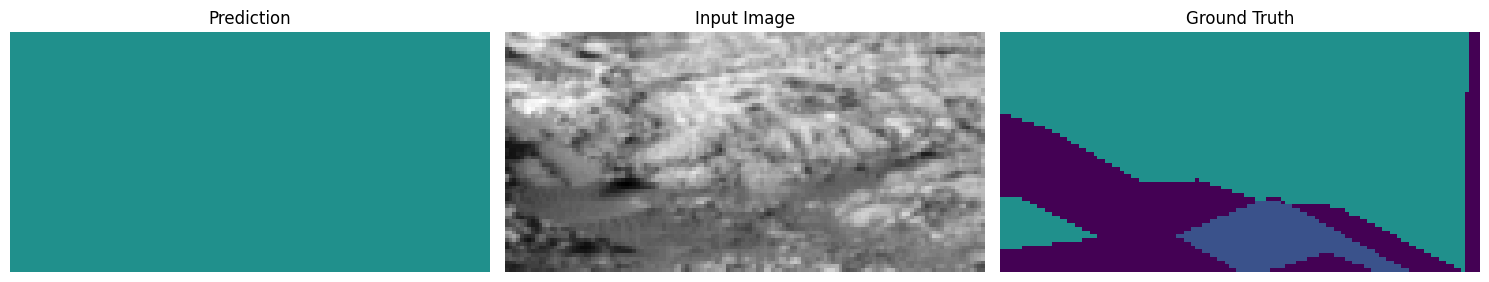

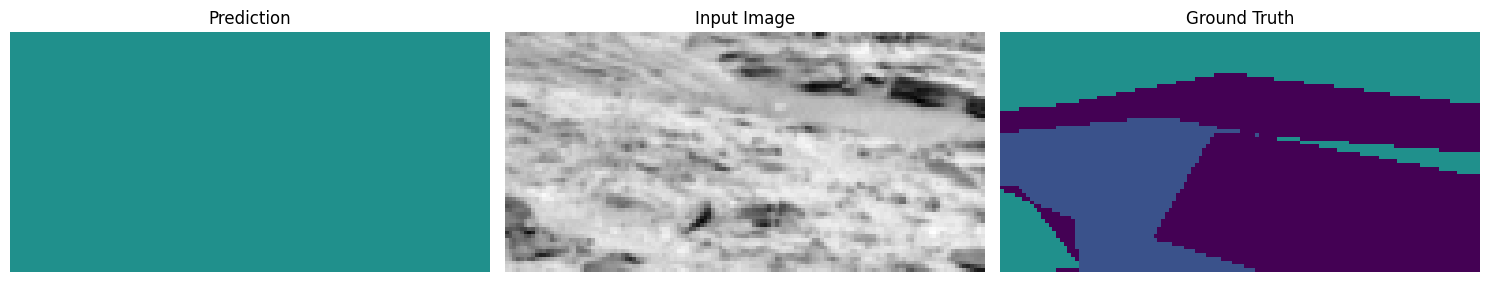

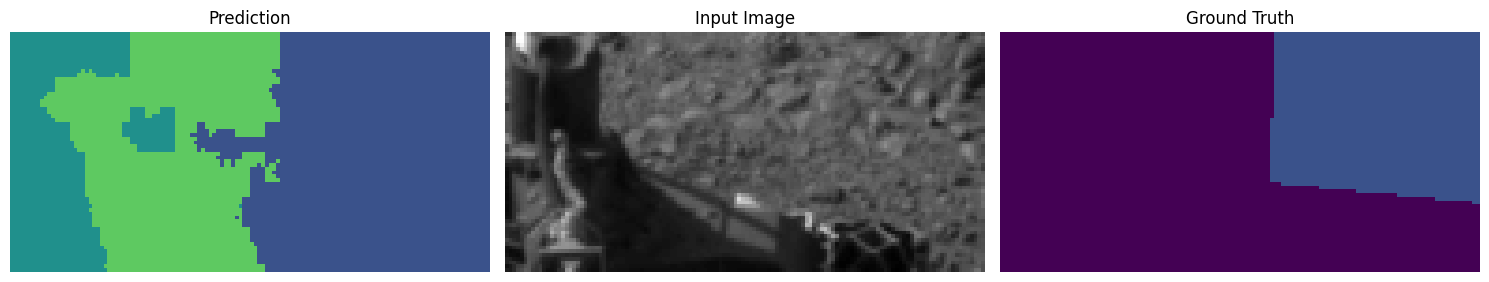

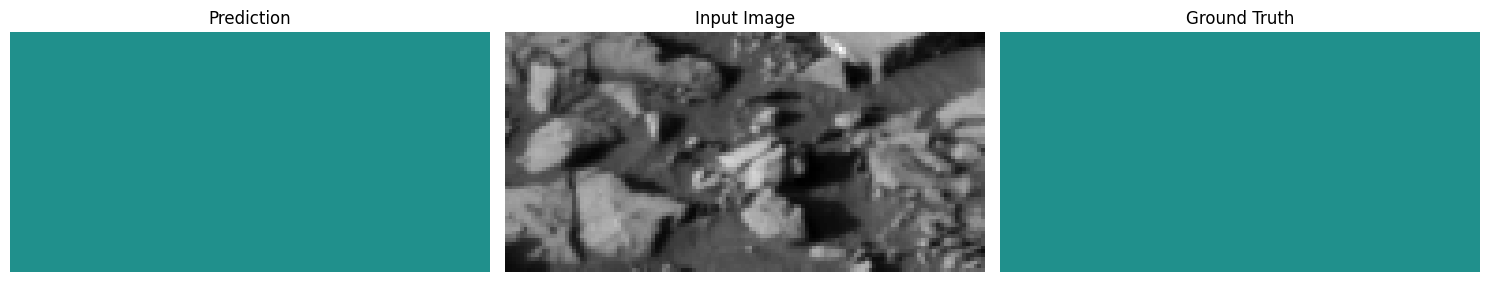

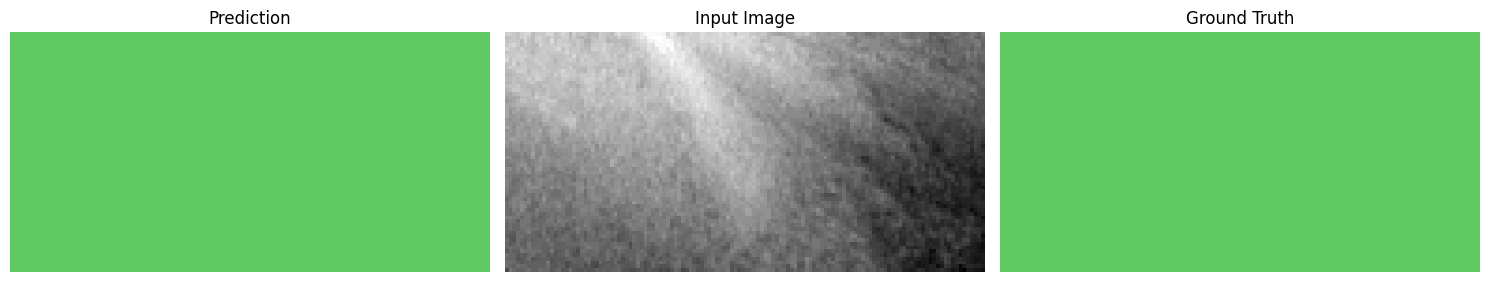

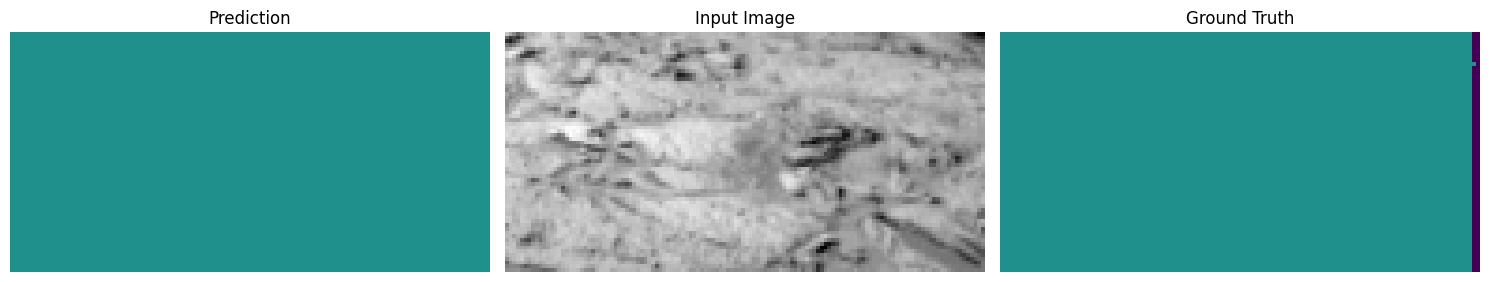

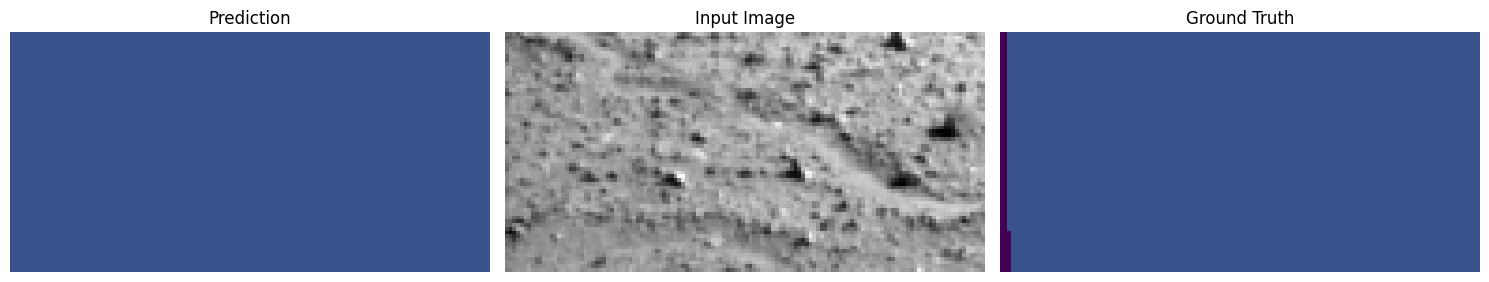

In [25]:
preds = model.predict(test_dataset)
predicted_classes = np.argmax(preds, axis=-1)
print(preds.shape)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
#print(test_lbl[0])
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
colormap = create_segmentation_colormap(num_classes)
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)
  colored_truth = apply_colormap(test_lbl[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(colored_truth)
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step


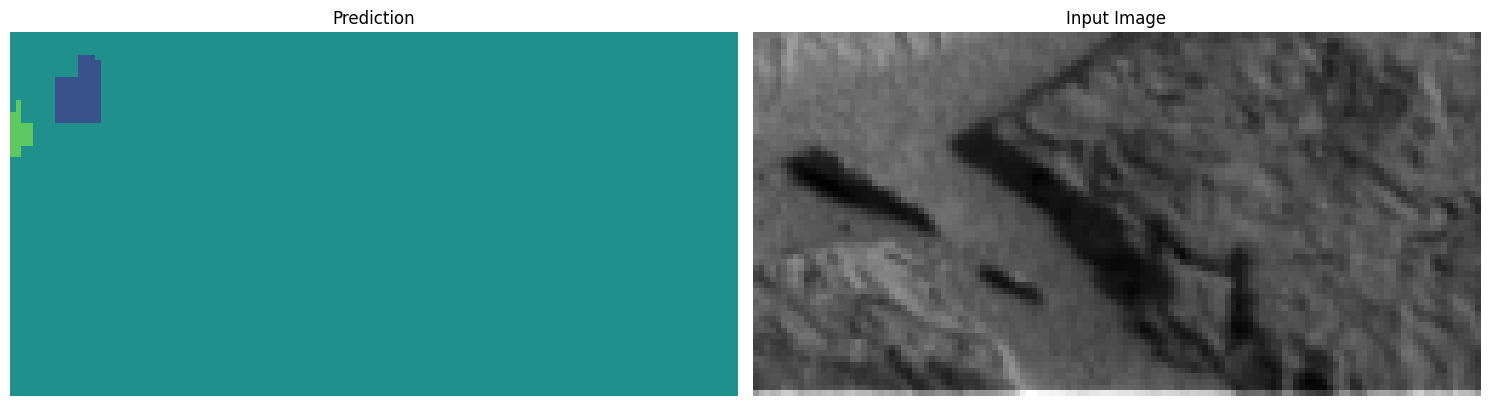

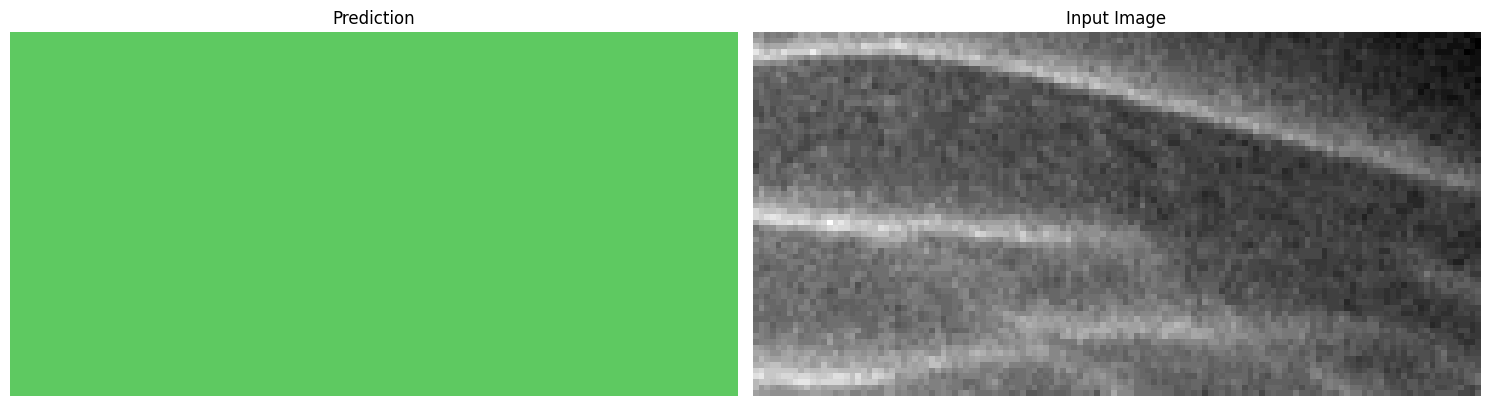

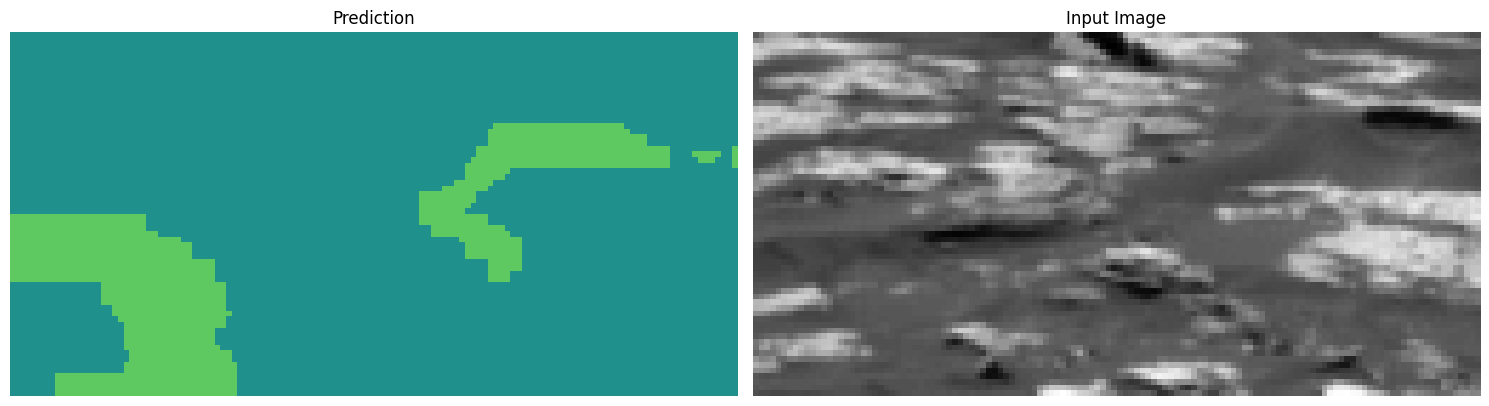

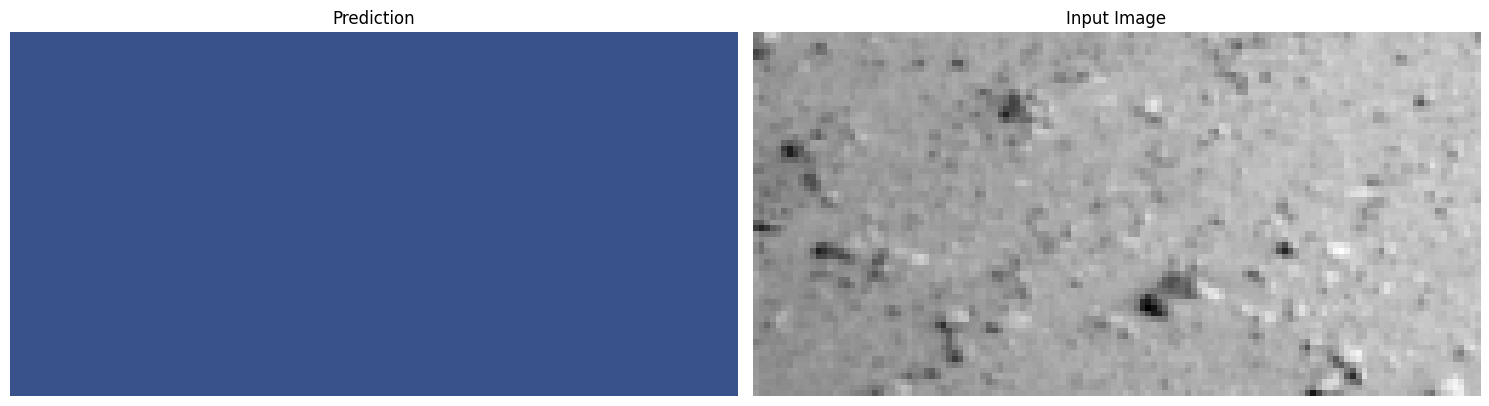

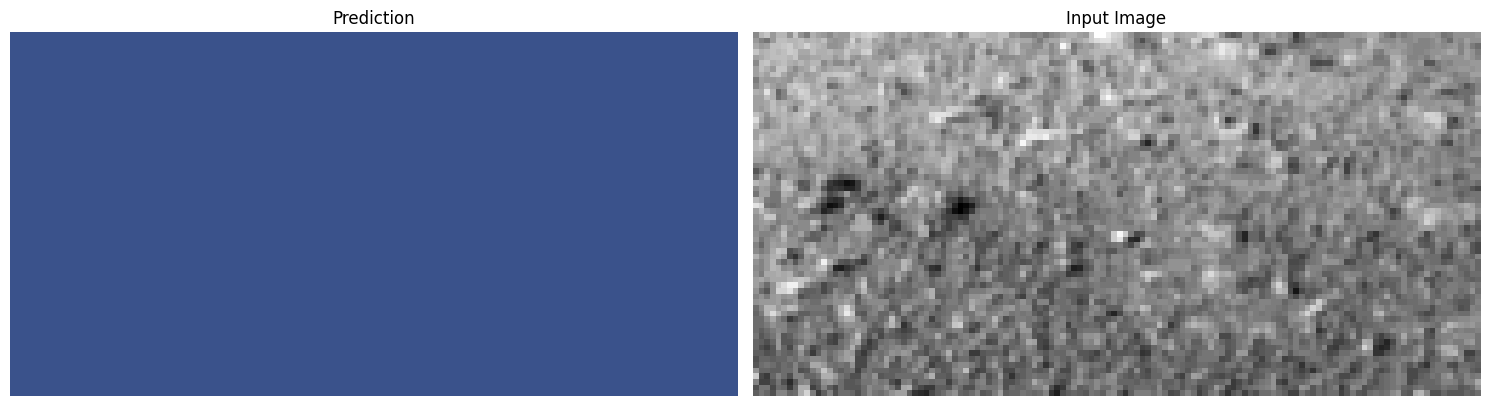

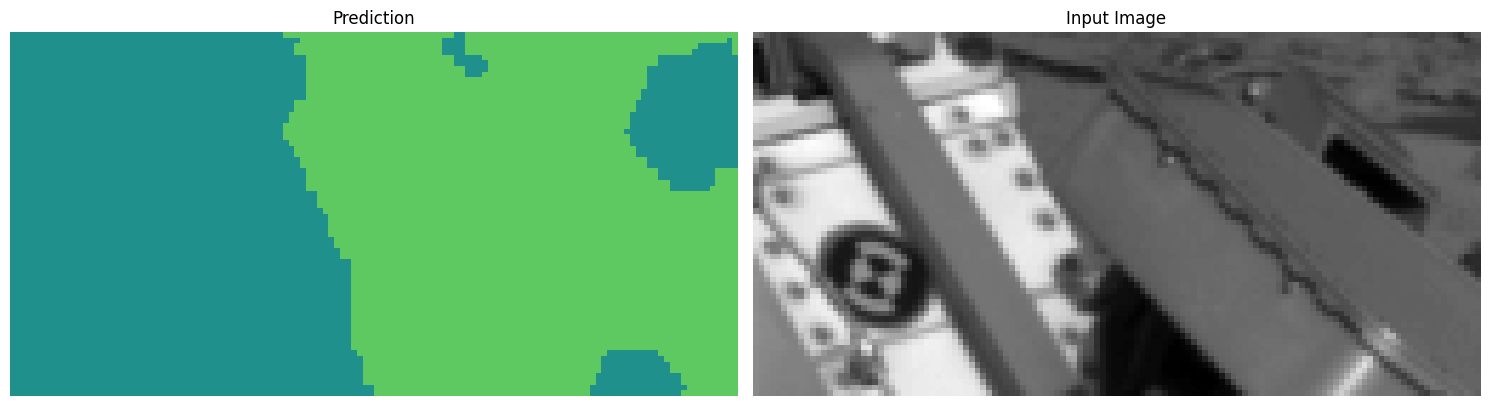

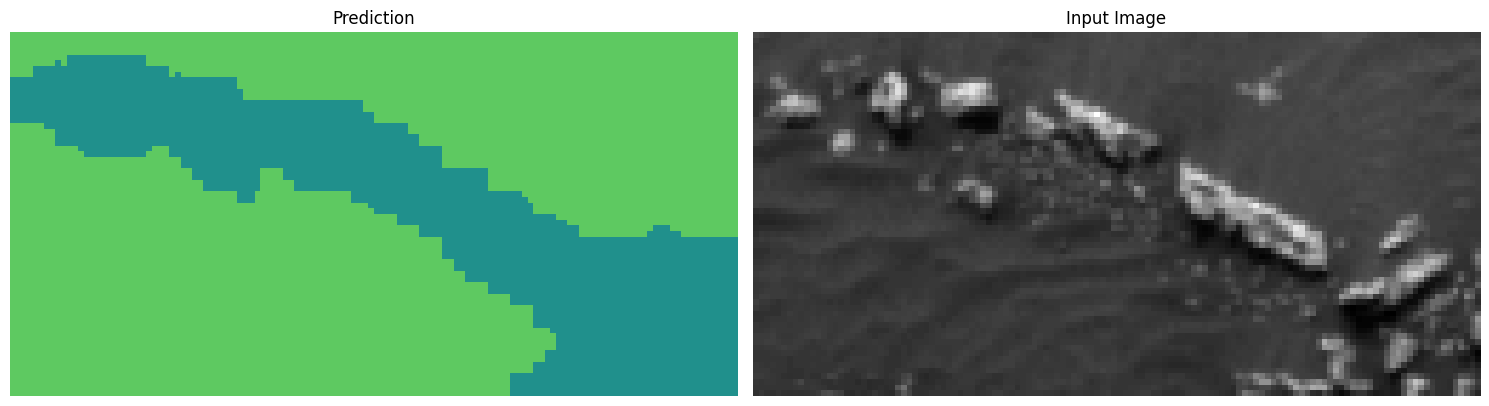

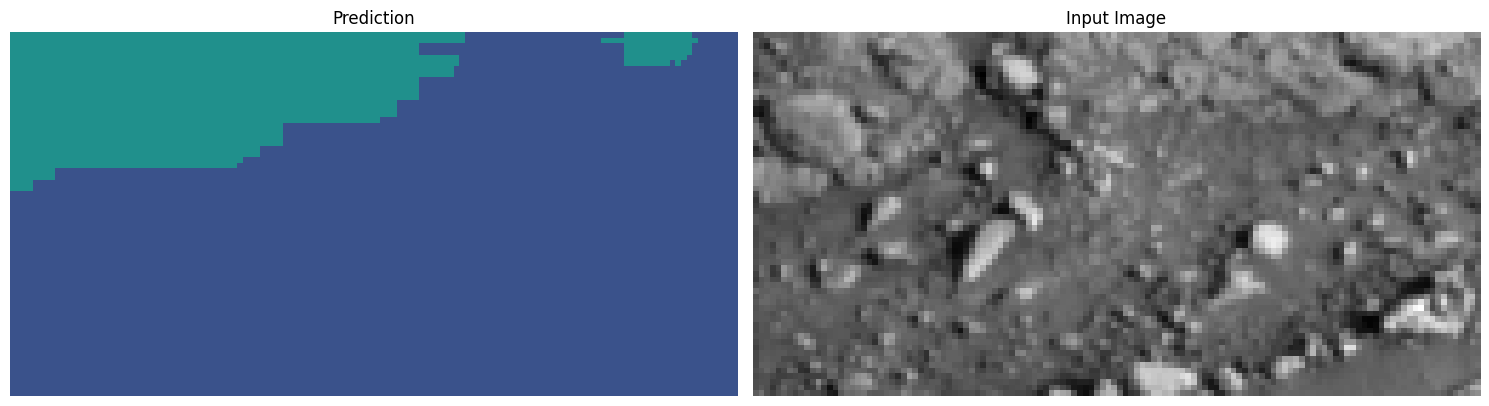

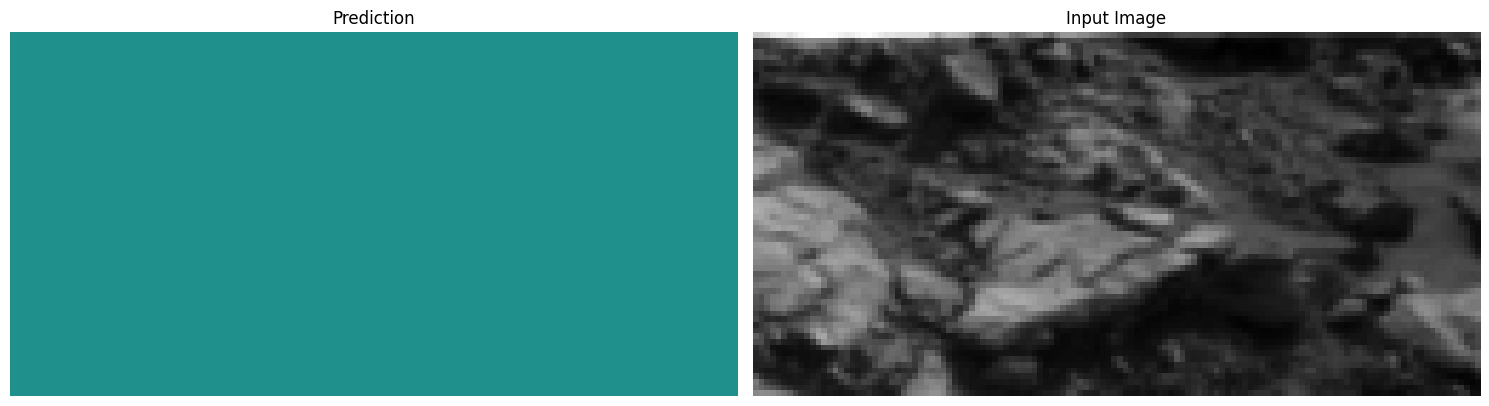

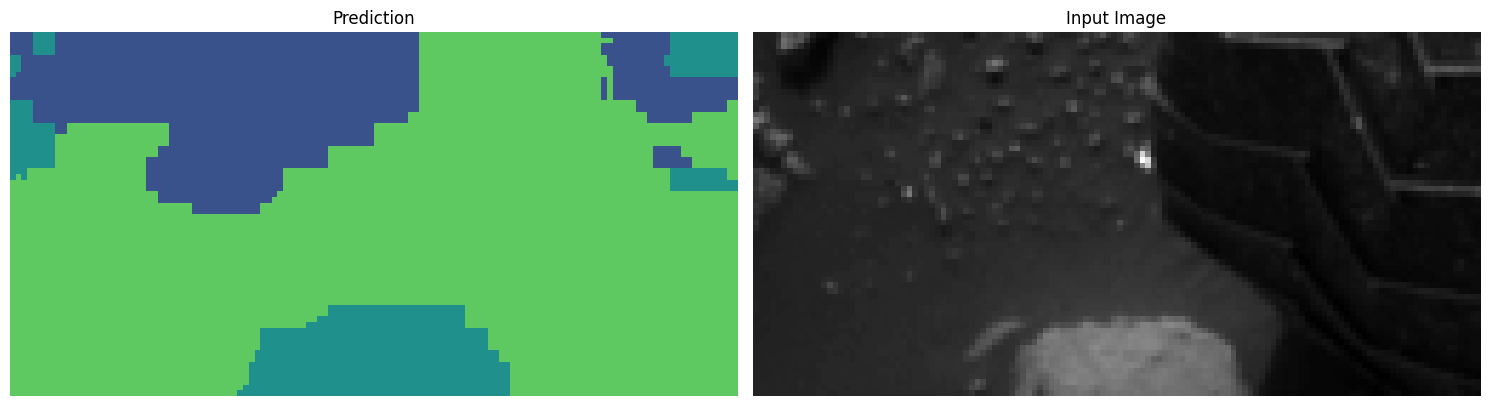

In [26]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure with 3 subplots

  colored_label = apply_colormap(preds[i], colormap)

  # Prediction
  axes[0].imshow(colored_label)
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(submission_filename)
from google.colab import files
files.download(submission_filename)

In [ ]:
#nr of rows
print(submission_df.shape)

In [ ]:
# disconnect
from google.colab import runtime
runtime.unassign()


#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```